<a href="https://colab.research.google.com/github/alzaidawi/PORTAL_code/blob/main/use_class_pore_detections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import pandas as pd
from IPython.display import Image, display
import matplotlib.pyplot as plt
from skimage import measure


In [ ]:
class PoreDetector:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image = cv2.imread(self.image_path)
        self.cropped_image = self.image[:, 300:1600]  # crop the width of the image to remove scale info on bottom right
        # plt.imshow(self.image)
        self.gray = cv2.cvtColor(self.cropped_image, cv2.COLOR_BGR2GRAY)
        # Image Smoothing techniques to help us in reducing the noise: e.g. Apply Gaussian filter or medianBlur
        self.gray = cv2.GaussianBlur(self.gray,(5,5),0)
        #self.gray = cv2.medianBlur(self.gray, 5)

        self.cropped_image_workpiece = np.copy(self.cropped_image)
        self.pore_count = 0
        self.pore_shapes = []
        self.pore_aspect_ratios = []
        self.pore_angles = []
        self.pore_center_x = []
        self.pore_center_y = []
        self.pore_orientations = []
        self.pore_density = 0
        self.pore_area_density = []
        self.pore_area = []
        self.pore_com_x = 0
        self.pore_com_y = 0
        self.max_pore_center_x = 0
        self.max_pore_center_y = 0
        self.overall_pore_area_density = 0
        self.pixel2mm_scalingfactor = 0.004  # I used ImageJ to calculate the optical scalling factor (convert from pixel to mm)
        self.circularity = []
        self.pore_index = []
        self.extent = []
        self.solidity = []
        self.equi_diameter = []
        self.convexity = []

    def detect_pores(self):
        self.ret, self.thresh = cv2.threshold(self.gray, 200, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(self.thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        
        max_cnt = max(contours, key = cv2.contourArea)
        # print('max_cnt', max_cnt)
        M = cv2.moments(max_cnt)
        max_pore_center_x =  int(M["m10"]/M["m00"])
        max_pore_center_y =  int(M["m01"]/M["m00"])
        blue_color = (255, 0, 0)
        cv2.drawMarker(self.cropped_image, (max_pore_center_x, max_pore_center_y), blue_color, cv2.MARKER_CROSS, markerSize=20, thickness=2)  # blue marker is center of max of the pores
            
        workpiece_area = (cv2.contourArea(max_cnt))*(self.pixel2mm_scalingfactor**2) # area of the largest contour which is the workpiece in mm2
        cv2.drawContours(self.cropped_image, contours, -1, (255,0,255))
        cv2.drawContours(self.cropped_image_workpiece, max_cnt, -1, (255,0,255),2)  # plot the workpiece contour in different color

        total_pore_area = 0

        # ###The more convex the more circle-like the contours are
        # # Contour is enclosed by convex hull
        # # Number of convex defects is counted --> More convexity defects, the lower the total convexity
        # convex_hulls = [cv2.convexHull(cnt) for cnt in contours]

        # #convexity_defects = cv2.convexityDefects(cnt, convexhull)
        # convexity_defects = [cv2.convexityDefects(contour, convex_hulls[i]) for i, contour in enumerate(contours)]
        # self.convexity_defects.append(convexity_defects)
        # # the larger the mean convexity error, the lower the convexity
        # convexity = sum([defect[3] for defect in convexity_defects])/len(convexity_defects)
        # self.convexity.append(convexity)

        for cnt in contours:
            moments = cv2.moments(cnt)
            if cv2.contourArea(cnt) != workpiece_area:  # if the current contour area is not equal to workpiece area 
              if moments['m00'] != 0:
                  x = int(moments['m10']/moments['m00']) #%
                  y = int(moments['m01']/moments['m00']) #%
                  
                  x = x*self.pixel2mm_scalingfactor # in mm
                  y = y*self.pixel2mm_scalingfactor # in mm
                  
                  self.pore_center_x.append((x))
                  self.pore_center_y.append((y))
                  rect = cv2.minAreaRect(cnt) #%
                  (cx, cy), (w, h), angle = rect # No conversion reqird in the aspect ratio the unit divided
                  aspect_ratio = max(w, h) / min(w, h) 
                  self.pore_aspect_ratios.append(aspect_ratio)
                  self.pore_angles.append(angle)
                  # Get the shape of the contour
                  if aspect_ratio >= 8:
                      self.pore_shapes.append("line")
                  elif aspect_ratio > 1 and aspect_ratio < 8:
                      self.pore_shapes.append("ellipse")
                  else:
                      self.pore_shapes.append("circle")
                  if w > h:
                      self.pore_orientations.append("horizontal")
                  elif h > w:
                    self.pore_orientations.append("vertical")
                  else:
                      self.pore_orientations.append("circle")
                  self.pore_count += 1

                  area_cnt = (cv2.contourArea(cnt))*(self.pixel2mm_scalingfactor**2) # convert to mm2
                  self.pore_area.append(area_cnt)
                  pore_area_density = area_cnt / (self.gray.shape[0] * self.gray.shape[1] * self.pixel2mm_scalingfactor**2)
                  self.pore_area_density.append(pore_area_density) #%
                  total_pore_area = total_pore_area + area_cnt
                  self.pore_com_x = self.pore_com_x + x*area_cnt
                  self.pore_com_y = self.pore_com_y + y*area_cnt

                  # compute the circularity of the contour
                  perimeter = cv2.arcLength(cnt, True) #calculate perimeter of the pore
                  circularity = 4 * np.pi * (area_cnt / (perimeter * perimeter))
                  self.circularity.append(circularity)  

                  # compute the Extent which is the ratio of contour area to bounding rectangle area. of the contour
                  rect_area = w*h
                  extent = float(area_cnt)/(rect_area *(self.pixel2mm_scalingfactor**2))
                  self.extent.append(extent)
                  
                  # Solidity is the ratio of contour area to its convex hull area.
                  hull = cv2.convexHull(cnt)
                  hull_area = (cv2.contourArea(hull))*(self.pixel2mm_scalingfactor**2)
                  solidity = float(area_cnt)/hull_area
                  self.solidity.append(solidity)

                  # Equivalent Diameter is the diameter of the circle whose area is same as the contour area.
                  equi_diameter = np.sqrt(4*area_cnt/np.pi)
                  self.equi_diameter.append(equi_diameter)

                  # eccentricity = measure.regionprops_table(cnt, properties=['eccentricity'])
                  # # self.eccentricity.append(eccentricity)
                  # print('eccentricity',eccentricity)
            
        self.pore_com_x = self.pore_com_x/total_pore_area
        self.pore_com_y = self.pore_com_y/total_pore_area
        #self.pore_density = self.pore_count / (self.gray.shape[0] * self.gray.shape[1])  # this was wrong since it takes the full image area including black borders
        self.pore_density = self.pore_count / workpiece_area
        #self.overall_pore_area_density = total_pore_area / (self.gray.shape[0] * self.gray.shape[1])
        self.overall_pore_area_density = total_pore_area / workpiece_area
      
        return self.pore_count

    def save_results_per_image(self):
        # Create a dictionary to store the results
        results = {"pore_count": self.pore_count,
                    "pore_shapes": self.pore_shapes,
                    "pore_aspect_ratios": self.pore_aspect_ratios,
                    "pore_angles": self.pore_angles,
                    "pore_center_x": self.pore_center_x,
                    "pore_center_y": self.pore_center_y,
                    "pore_orientations": self.pore_orientations,
                    "pore_density": self.pore_density,
                    "pore_area_density": self.pore_area_density,
                    "pore_area": self.pore_area,
                    "overall_pore_area_density": self.overall_pore_area_density,
                    "pore_com_x": self.pore_com_x,
                    "pore_com_y": self.pore_com_y,
                    "circularity": self.circularity,
                    "extent": self.extent,
                    "solidity": self.solidity,
                    "equi_diameter": self.equi_diameter}


        # Convert the dictionary to a DataFrame
        df = pd.DataFrame(results)

        # Save the DataFrame to a CSV file
        df.to_csv("{}_pores_results.csv".format(self.image_path), index=False)

        # plot the overall center of mass of the pores
        x, y = int(self.pore_com_x/self.pixel2mm_scalingfactor), int(self.pore_com_y/self.pixel2mm_scalingfactor) # convert back to pixel for plotting COM on the image
        green_color = (0, 255, 0)
        markerType = cv2.MARKER_CROSS
        markerSize = 20
        thickness = 2
        # cv2.drawMarker(self.cropped_image, (x, y), green_color, markerType, markerSize, thickness)  # green marker is center of mass of the pores

        # center of the image 
        cx, cy = int(self.cropped_image.shape[1]/2), int(self.cropped_image.shape[0]/2)
        red_color = (0, 0, 255)
        cv2.drawMarker(self.cropped_image, (cx, cy), red_color, markerType, markerSize, thickness)  # red marker is the center of the image
        
        # Save the original image with the contours
        cv2.imwrite("{}_pores_detected.jpg".format(self.image_path), self.cropped_image)
        
        # Save the original image with the detected workpiece
        cv2.imwrite("{}_workpiece_detected.jpg".format(self.image_path), self.cropped_image_workpiece)

        # Save the thresholded image
        plt.imsave("{}_pores_thresholded.jpg".format(self.image_path), self.thresh, cmap='gray')

        # Save the grayscale image
        cv2.imwrite("{}_pores_grayscale.jpg".format(self.image_path), self.gray)


    


Some open CV features:

https://docs.opencv.org/3.4/d1/d32/tutorial_py_contour_properties.html

In [ ]:
image = PoreDetector('/content/001.JPG')
image.detect_pores();
image.save_results_per_image()

In [ ]:
# Check howmany lines do we have in each image just to check if filling color is correct 
#(here we should have only 11 red lines but the image shows alot red circles and ellips)
lines = []
circles = []
ellips = []
statistictics = pd.read_csv("/content/001.JPG_pores_results.csv")
for n in statistictics['pore_shapes']:
  if n == 'line':
    lines.append(n)
  elif n == 'ellipse':
    ellips.append(n)
  else:
    circles.append(n)

print(len(lines))
print(len(ellips))
print(len(circles))

0
364
86


Threshold:     number of pores:
150   342
175   367
200    456
205    567
210    1382
215    6918
220    10077
225    7

In [ ]:
##rm -rf 'folder path' ## dengarous will delete all the folder 

In [ ]:
import os
import csv

images = []

# path to the directory with the images
directory = '/content/data_images/'
index=0
# loop through each item in the directory
for item in os.listdir(directory):
    # check if the item is an image
    if item.endswith('.JPG'):
      image = PoreDetector(directory+item)
      image.detect_pores()
      image.save_results_per_image()
    
    if item.endswith('.csv'):
      #print(item["pore_angles"].mean())
      image_id=item.split(".",1)[-2]   ### image id
      data= pd.read_csv('/content/data_images/'+item)
      print('image ID', image_id)
      print('Number of pores',data['pore_count'].mean())
      
      #print('statistics',data['pore_density'].describe())
      #print('median',data['pore_density'].median())
      #print('var',data['pore_density'].var())

      ## save over_all_statistics:
      df_over_all_images = pd.DataFrame({"Index/Bildnummer" : [image_id],
                                         "pore_count" : [np.mean(data['pore_count'])],
                                         "overall_pore_area_density" : [np.mean(data['overall_pore_area_density'])],

                                         "mean_pore_aspect_ratios" : [np.mean(data['pore_aspect_ratios'])],
                                         "min_pore_aspect_ratios" : [np.min(data['pore_aspect_ratios'])],
                                         "max_pore_aspect_ratios" : [np.max(data['pore_aspect_ratios'])],
                                         "median_pore_aspect_ratios" : [np.median(data['pore_aspect_ratios'])],
                                         "var_pore_aspect_ratios" : [np.var(data['pore_aspect_ratios'])],
                                         "std_pore_aspect_ratios" : [np.std(data['pore_aspect_ratios'])],
                                         "total_pore_aspect_ratios" : [np.sum(data['pore_aspect_ratios'])],
                                        
                                         "mean_pore_angles" : [np.mean(data['pore_angles'])],
                                         "min_pore_angles" : [np.min(data['pore_angles'])],
                                         "max_pore_angles" : [np.max(data['pore_angles'])],
                                         "median_pore_angles" : [np.median(data['pore_angles'])],
                                         "var_pore_angles" : [np.var(data['pore_angles'])],
                                         "std_pore_angles" : [np.std(data['pore_angles'])],
                                         "total_pore_angles" : [np.sum(data['pore_angles'])],
                                         
                                         "mean_pore_area" : [np.mean(data['pore_area'])],
                                         "min_pore_area" : [np.min(data['pore_area'])],
                                         "max_pore_area" : [np.max(data['pore_area'])],
                                         "median_pore_area" : [np.median(data['pore_area'])],
                                         "var_pore_area" : [np.var(data['pore_area'])],
                                         "std_pore_area" : [np.std(data['pore_area'])],
                                         "total_pore_area" : [np.sum(data['pore_area'])],

                                         "mean_pore_com_x" : [np.mean(data['pore_com_x'])],
                                         "mean_pore_com_y" : [np.mean(data['pore_com_y'])],

                                         "count_line_shape" : [len(data[data['pore_shapes']=='line'])],
                                         "count_ellipse_shape" : [len(data[data['pore_shapes']=='ellipse'])],
                                         "count_circle_shape" : [len(data[data['pore_shapes']=='circle'])],
                                        
                                        "count_vertical" : [len(data[data['pore_orientations']=='vertical'])],
                                         "count_no_direction" : [len(data[data['pore_orientations']=='circle'])],
                                         "count_horizontal" : [len(data[data['pore_orientations']=='horizontal'])],
                                        
                                         "mean_circularity" : [np.mean(data['circularity'])],
                                         "min_circularity" : [np.min(data['circularity'])],
                                         "max_circularity" : [np.max(data['circularity'])],
                                         "median_circularity" : [np.median(data['circularity'])],
                                         "var_circularity" : [np.var(data['circularity'])],
                                         "std_circularity" : [np.std(data['circularity'])],
                                         "total_circularity" : [np.sum(data['circularity'])],
                                         
                                          "mean_extent" : [np.mean(data['extent'])],
                                         "min_extent" : [np.min(data['extent'])],
                                         "max_extent" : [np.max(data['extent'])],
                                         "median_extent" : [np.median(data['extent'])],
                                         "var_extent" : [np.var(data['extent'])],
                                         "std_extent" : [np.std(data['extent'])],
                                         "total_extent" : [np.sum(data['extent'])],
                                         
                                         "mean_solidity" : [np.mean(data['solidity'])],
                                         "min_solidity" : [np.min(data['solidity'])],
                                         "max_solidity" : [np.max(data['solidity'])],
                                         "median_solidity" : [np.median(data['solidity'])],
                                         "var_solidity" : [np.var(data['solidity'])],
                                         "std_solidity" : [np.std(data['solidity'])],
                                         "total_solidity" : [np.sum(data['solidity'])],
                                         
                                         "mean_equi_diameter" : [np.mean(data['equi_diameter'])],
                                         "min_equi_diameter" : [np.min(data['equi_diameter'])],
                                         "max_equi_diameter" : [np.max(data['equi_diameter'])],
                                         "median_equi_diameter" : [np.median(data['equi_diameter'])],
                                         "var_equi_diameter" : [np.var(data['equi_diameter'])],
                                         "std_equi_diameter" : [np.std(data['equi_diameter'])],
                                         "total_equi_diameter" : [np.sum(data['equi_diameter'])]})

      df_over_all_images.to_csv("statistictics_over_all_images.csv", index=False, mode='a', header=False)

#female_able = df_norm_fix_features[df_norm_fix_features['user_id'].str.endswith('4')].reset_index(drop=True)




image ID 146
Number of pores 71.0
image ID 228
Number of pores 159.0
image ID 282
Number of pores 71.0
image ID 185
Number of pores 123.0
image ID 174
Number of pores 70.0
image ID 139
Number of pores 259.0
image ID 171
Number of pores 57.0
image ID 332
Number of pores 125.0
image ID 074
Number of pores 98.0
image ID 030
Number of pores 147.0
image ID 300
Number of pores 90.0
image ID 218
Number of pores 50.0
image ID 193
Number of pores 64.0
image ID 321
Number of pores 76.0
image ID 046
Number of pores 245.0
image ID 067
Number of pores 150.0
image ID 313
Number of pores 54.0
image ID 339
Number of pores 112.0
image ID 059
Number of pores 119.0
image ID 068
Number of pores 77.0
image ID 291
Number of pores 94.0
image ID 217
Number of pores 53.0
image ID 089
Number of pores 273.0
image ID 275
Number of pores 152.0
image ID 370
Number of pores 54.0
image ID 183
Number of pores 83.0
image ID 180
Number of pores 104.0
image ID 160
Number of pores 79.0
image ID 197
Number of pores 101.0
i

In [ ]:
## add the header to our overall features csv file
import csv
file='/content/statistictics_over_all_images.csv'
with open(file,newline='') as f:
    r = csv.reader(f)
    data = [line for line in r]
with open(file,'w',newline='') as f:
    w = csv.writer(f)
    w.writerow(["Index/Bildnummer","pore_count", "overall_pore_area_density" , "mean_pore_aspect_ratios", "min_pore_aspect_ratios", 
                "max_pore_aspect_ratios", "median_pore_aspect_ratios", "var_pore_aspect_ratios", "std_pore_aspect_ratios", 
                "total_pore_aspect_ratios", "mean_pore_angles", "min_pore_angles", "max_pore_angles", "median_pore_angles" ,
                "var_pore_angles" , "std_pore_angles" , "total_pore_angles" , "mean_pore_area" , "min_pore_area" , "max_pore_area" ,
                "median_pore_area" , "var_pore_area" , "std_pore_area" , "total_pore_area" , "mean_pore_com_x", "mean_pore_com_y" ,
                "count_line_shape" , "count_ellipse_shape" , "count_circle_shape", "count_vertical", "count_no_direction", "count_horizontal"
                , "mean_circularity", "min_circularity", "max_circularity", "median_circularity", "var_circularity", "std_circularity", "total_circularity",
                "mean_extent", "min_extent", "max_extent", "median_extent", "var_extent", "std_extent", "total_extent", "mean_solidity", "min_solidity",
                "max_solidity", "median_solidity", "var_solidity", "std_solidity", "total_solidity", "mean_equi_diameter", "min_equi_diameter", "max_equi_diameter",
                "median_equi_diameter", "var_equi_diameter", "std_equi_diameter", "total_equi_diameter"])
    w.writerows(data)

                                        

In [ ]:
from google.colab import files
!zip -r /content/data_images.zip /content/data_images
files.download('/content/data_images.zip')


In [ ]:
##  convert the seperatore of the file to comma so it can be better handled it in DataFrame.
import csv

reader = csv.reader(open("/content/Parametkombinationen.CSV", "r"), delimiter=';')
writer = csv.writer(open("/content/Parametkombinationen_n.CSV", 'w'), delimiter=',')
writer.writerows(reader)

In [ ]:
## Sort and merge the overall statistics with the parameters CSV file
import sys
import glob
sys.path.append('../')
import numpy as np
import datetime
import pandas as pd
from matplotlib.pyplot import figure
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import argparse


Parametkombinationen_all_images = pd.read_csv("/content/Parametkombinationen_n.CSV")
#print(Parametkombinationen_all_images[0:3])

statistictics_over_all_images = pd.read_csv("/content/statistictics_over_all_images.csv")
#print(statistictics_over_all_images[0:3])


statistictics_over_all_images.sort_values(["Index/Bildnummer"],axis=0, ascending=True,inplace=True,na_position='first')
#print("\nSorted CSV file (according to multiple columns) = \n", statistictics_over_all_images[0:3])

merged_result = pd.merge(statistictics_over_all_images, Parametkombinationen_all_images, on="Index/Bildnummer")
merged_result.to_csv("merged_result.csv", index=False)
#print('merged csv file', merged_result)


In [ ]:
## visulizing the features:
import matplotlib.pyplot as plt
import sys
import glob
sys.path.append('../')
import numpy as np
import datetime
import pandas as pd
from matplotlib.pyplot import figure
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import argparse


statistictics_over_all_images = pd.read_csv("/content/merged_result.csv")
print('columns of the merged results file',statistictics_over_all_images.columns)

image_id = statistictics_over_all_images['Index/Bildnummer']
# plt.bar(image_id, statistictics_over_all_images['overall_pore_area_density'], color = 'b', width = 0.8, label='??')
# # plt.legend(loc='upper center', fontsize=15)
# plt.ylim([0, 1])
# plt.xlim([0, 400])
# # plt.ylabel('Total density', fontsize=15)
# plt.ylabel('Total density', fontsize=20)
# plt.xlabel('Image ID', fontsize=20)
# plt.xticks(np.arange(1, 415, 15), rotation='vertical')  ## with BioEye data
# plt.yticks(np.arange(0, 1, 0.05))
# # plt.grid(True)
# # plt.show()
#############################
#mode='lines+markers'
fig = make_subplots(rows=6, cols=1, shared_xaxes=True, vertical_spacing=0.1)
fig.append_trace(go.Scatter(x=image_id, y=statistictics_over_all_images['overall_pore_area_density']*100, name="pore area density", mode='markers', marker=dict(size=2.5, color='black')),row=1, col=1)
fig.append_trace(go.Scatter(x=image_id, y=statistictics_over_all_images['total_pore_area']*100, name="pore area", mode='markers', marker=dict(size=2.5, color='black')),row=2, col=1)
fig.append_trace(go.Scatter(x=image_id, y=statistictics_over_all_images['pore_count'], name="Pores count", mode='markers', marker=dict(size=2.5, color='blue')),row=3, col=1)
fig.append_trace(go.Scatter(x=image_id, y=statistictics_over_all_images['count_circle_shape'], name="Count circles", mode='markers', marker=dict(size=2.5, color='green')),row=4, col=1)
fig.append_trace(go.Scatter(x=image_id, y=statistictics_over_all_images['count_ellipse_shape'], name="Count ellipse", mode='markers', marker=dict(size=2.5, color='green')),row=5, col=1)
fig.append_trace(go.Scatter(x=image_id, y=statistictics_over_all_images['count_line_shape'], name="Count lines", mode='markers', marker=dict(size=2.5, color='green')),row=6, col=1)
# Update layout and axes of the plot
#title = "Some features extracted over all images"
#fig.update_layout(title=title)
fig.update_layout(legend={'itemsizing': 'constant'})  # Legend symbol size is the same for all items
fig.update_layout(font_family="Computer Modern", font_color="black",plot_bgcolor='rgba(254, 245, 236, 1)',
    legend=dict(
        yanchor="top",
        xanchor="right",
        x=1.25,   ## to move the legend position
        y=0.7,
        font=dict(
            size=12,)))
fig.update_yaxes(title_text="p-density", title_standoff=16, row=1, col=1)
fig.update_yaxes(title_text="p-area", title_standoff=16, row=2, col=1)
fig.update_yaxes(title_text="Pores No", title_standoff=16, row=3, col=1)
fig.update_yaxes(title_text="circles", title_standoff=16, row=4, col=1)
fig.update_yaxes(title_text="Ellips", title_standoff=16, row=5, col=1)
fig.update_yaxes(title_text="Line", title_standoff=16, row=6, col=1)

fig.update_xaxes(overlaying='y', side='right', title_standoff=16, row=1, col=1)
fig.update_xaxes(tickangle = 90, title_standoff=16, row=2, col=1)
fig.update_xaxes(tickangle = 90, title_text="Images ID", title_standoff=16, row=6, col=1)


config = {
    'toImageButtonOptions': {
        'format': 'png',  # one of png, svg, jpeg, webp
        'height': 700,
        'width': 700,
        'scale': 4  # Multiply title/legend/axis/canvas sizes by this factor
         }}
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.show(config=config)

columns of the merged results file Index(['Index/Bildnummer', 'pore_count', 'overall_pore_area_density',
       'mean_pore_aspect_ratios', 'min_pore_aspect_ratios',
       'max_pore_aspect_ratios', 'median_pore_aspect_ratios',
       'var_pore_aspect_ratios', 'std_pore_aspect_ratios',
       'total_pore_aspect_ratios', 'mean_pore_angles', 'min_pore_angles',
       'max_pore_angles', 'median_pore_angles', 'var_pore_angles',
       'std_pore_angles', 'total_pore_angles', 'mean_pore_area',
       'min_pore_area', 'max_pore_area', 'median_pore_area', 'var_pore_area',
       'std_pore_area', 'total_pore_area', 'mean_pore_com_x',
       'mean_pore_com_y', 'count_line_shape', 'count_ellipse_shape',
       'count_circle_shape', 'count_vertical', 'count_no_direction',
       'count_horizontal', 'mean_circularity', 'min_circularity',
       'max_circularity', 'median_circularity', 'var_circularity',
       'std_circularity', 'total_circularity', 'mean_extent', 'min_extent',
       'max_extent', 

In [ ]:
## find Correlations:
import pandas as pd
data = pd.read_csv("/content/merged_result.csv")
df1=data.corr(method ='pearson')
#print(data.corr())
df2=data.corr()
df1.to_csv("coor_pearson.csv")
df2.to_csv("coor_panda.csv")

col Laser Power [W]


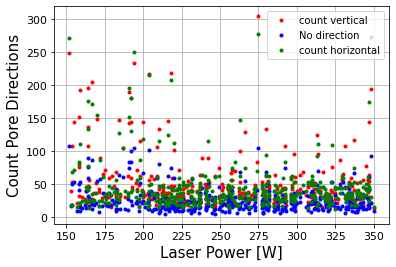

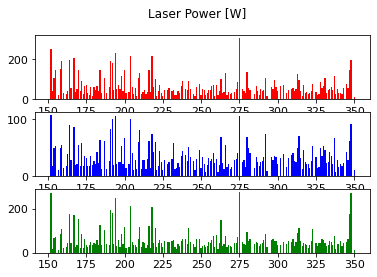

col Scan Speed [mm/s]


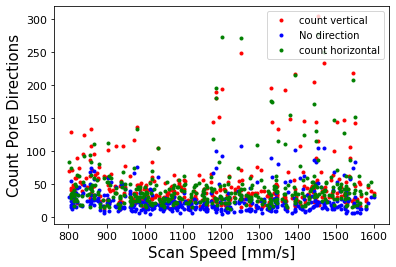

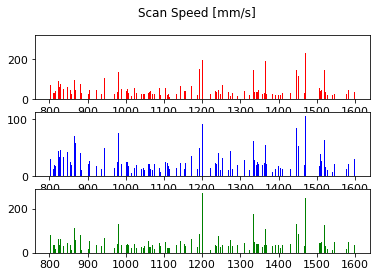

col Hatch Distance [mm]


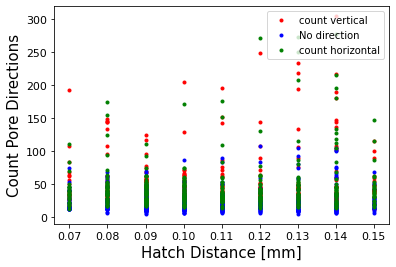

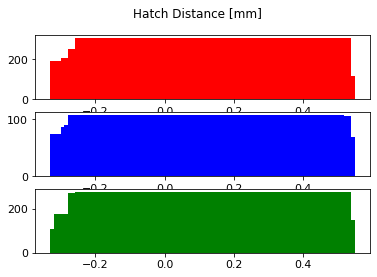

col Layer Thickness [mm]


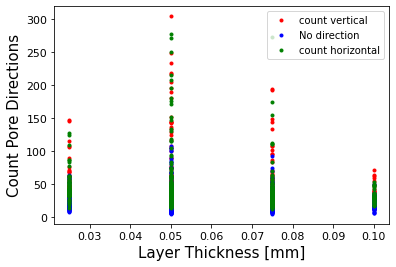

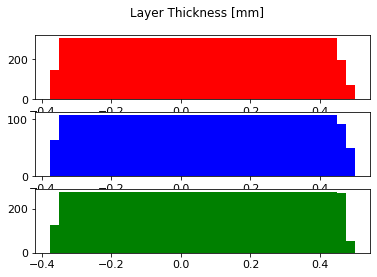

col VED [J/mm3]


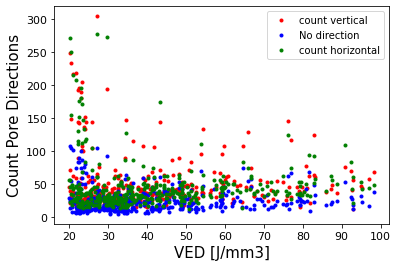

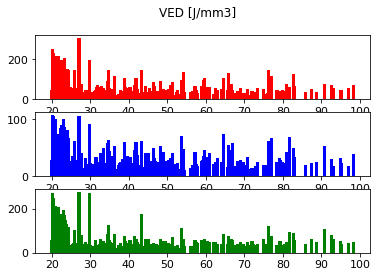

col TE [J/mm]


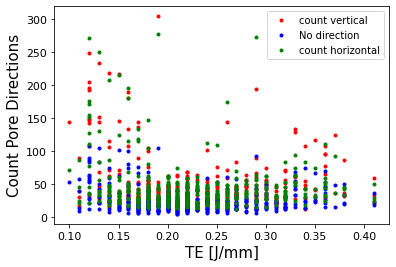

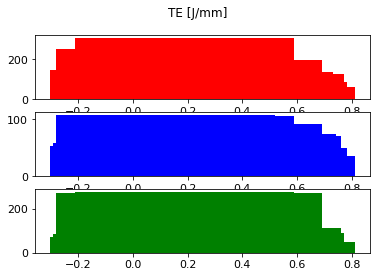

col Dichte [%] OTSU


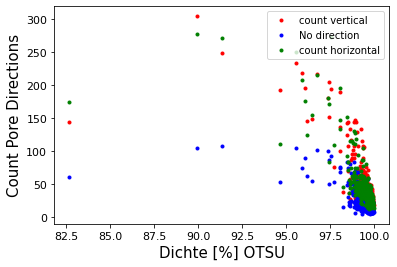

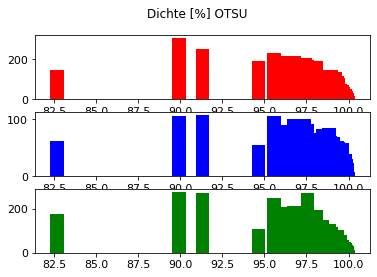

In [ ]:
## Plot count vertical directions (red) and count no directions (blue) count horizontal (green) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  
  process_param= results[col]
  count_vertical = results[ 'count_vertical']
  plt.plot(process_param, count_vertical, '.r', label='count vertical')
  # plt.bar(process_param, count_vertical, color='red', label='count vertical')

  count_no_direction = results[ 'count_no_direction']
  plt.plot(process_param, count_no_direction, '.b', label='No direction')
  # plt.bar(process_param, count_no_direction, color='blue', label='No direction')

  count_horizontal = results[ 'count_horizontal']
  plt.plot(process_param, count_horizontal, '.g', label='count horizontal')  
  # plt.bar(process_param, count_horizontal, color='green', label='count horizontal')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Count Pore Directions', fontsize=15)
  plt.legend(loc='upper right')

  fig, axs = plt.subplots(3)
  plt.suptitle(col)
  axs[0].bar(process_param, count_vertical, color='red')
  #axs[0].set_ylim([0.1, 400])
  axs[1].bar(process_param, count_no_direction, color='blue')
  #axs[1].set_ylim([0.1, 100])
  axs[2].bar(process_param, count_horizontal, color='green')
  #axs[2].set_ylim([0.1, 300])

  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  # plt.savefig("/content/pore_count_directions/count_direction_against_{}.jpg".format(col[0:5]))
  plt.show()


col Laser Power [W]


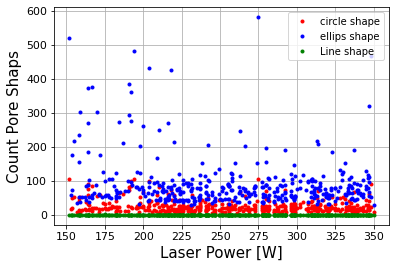

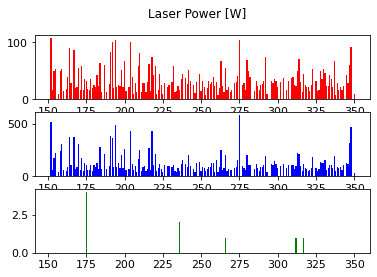

col Scan Speed [mm/s]


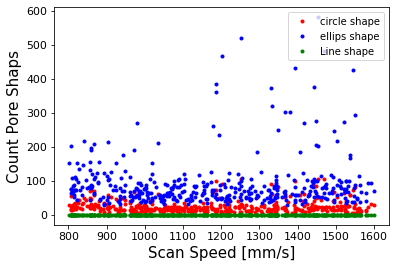

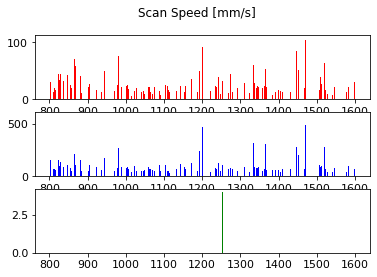

col Hatch Distance [mm]


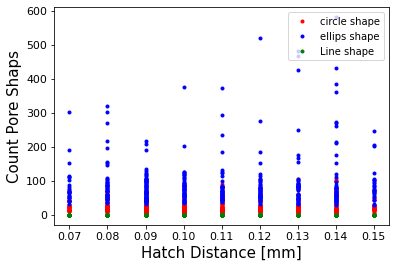

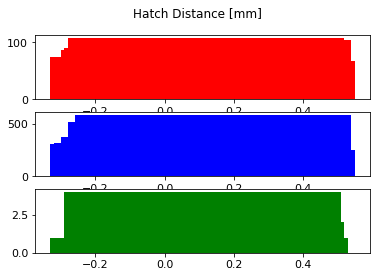

col Layer Thickness [mm]


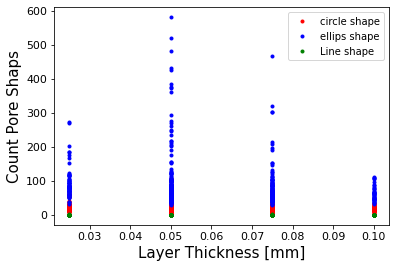

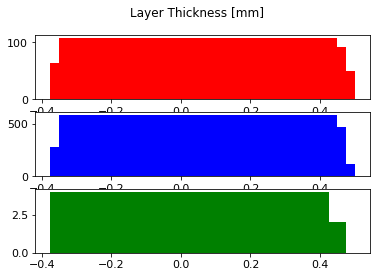

col VED [J/mm3]


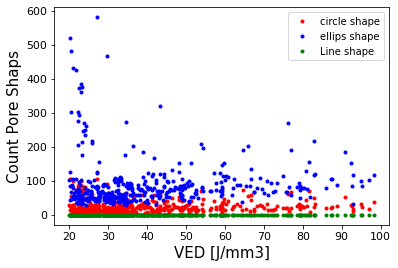

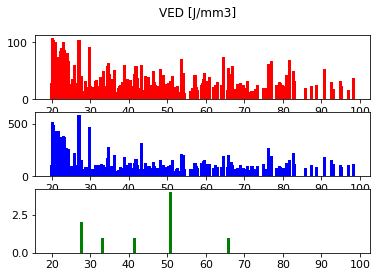

col TE [J/mm]


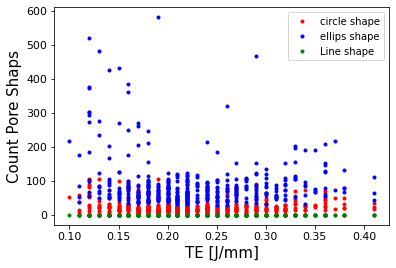

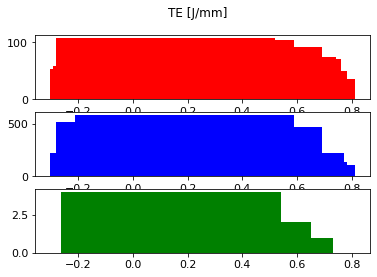

col Dichte [%] OTSU


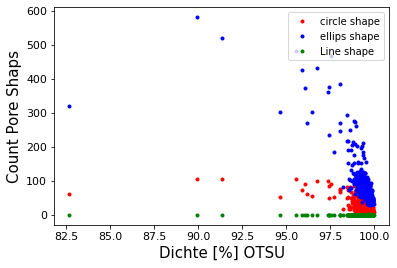

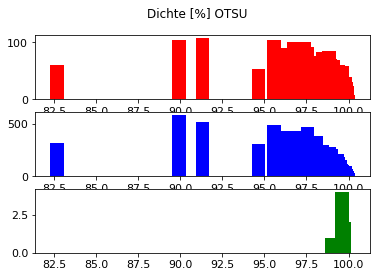

In [ ]:
## Plot count circles (red) and count ellips (blue) count lines (green) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]
  count_circle_shape = results[ 'count_circle_shape']
  plt.plot(process_param, count_circle_shape, '.r', label='circle shape')

  count_ellipse_shape = results[ 'count_ellipse_shape']
  plt.plot(process_param, count_ellipse_shape, '.b', label='ellips shape')

  count_line_shape = results[ 'count_line_shape']
  plt.plot(process_param, count_line_shape, '.g', label='Line shape')  

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Count Pore Shaps', fontsize=15)
  plt.legend(loc='upper right')

  fig, axs = plt.subplots(3)
  plt.suptitle(col)
  axs[0].bar(process_param, count_circle_shape, color='red')
  axs[1].bar(process_param, count_ellipse_shape, color='blue')
  axs[2].bar(process_param, count_line_shape, color='green')

  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  # plt.savefig("/content/pore_count_shapes/count_shape_against_{}.jpg".format(col[0:5]))
  plt.show()


col Laser Power [W]


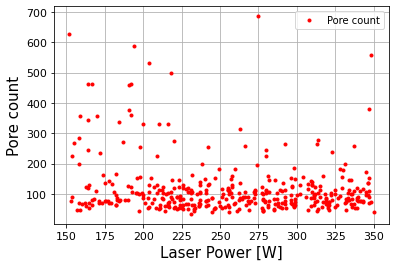

col Scan Speed [mm/s]


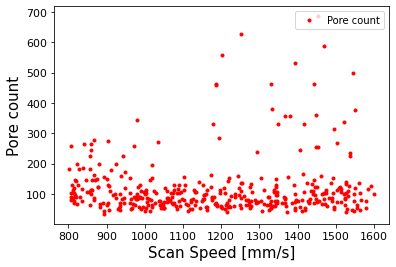

col Hatch Distance [mm]


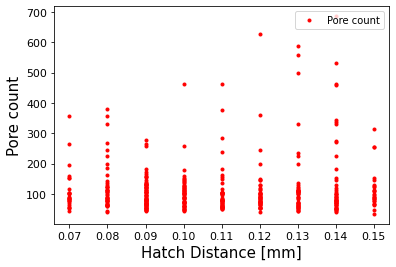

col Layer Thickness [mm]


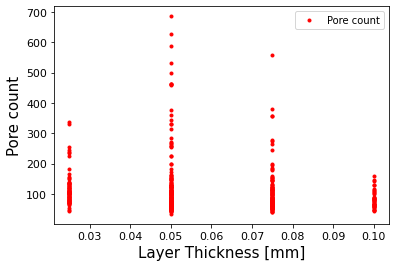

col VED [J/mm3]


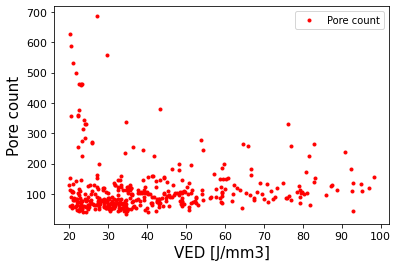

col TE [J/mm]


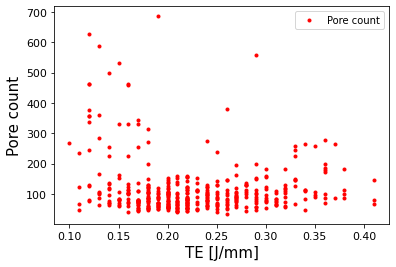

col Dichte [%] OTSU


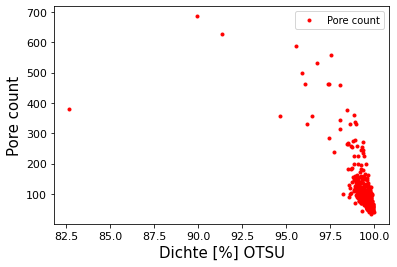

In [ ]:
## Plot pore count (red) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]
  pore_count = results[ 'pore_count']
  plt.plot(process_param, pore_count, '.r', label='Pore count')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Pore count', fontsize=15)
  plt.legend(loc='upper right')
  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  #plt.savefig("/content/pore_count/pore_count_and_density_against_{}.jpg".format(col[0:5]))
  plt.show()



col Laser Power [W]


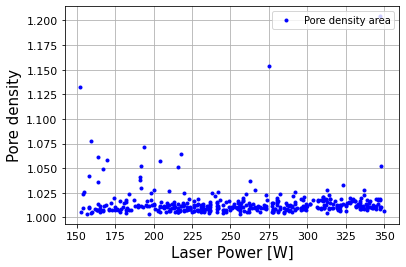

col Scan Speed [mm/s]


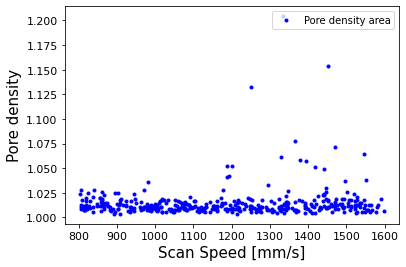

col Hatch Distance [mm]


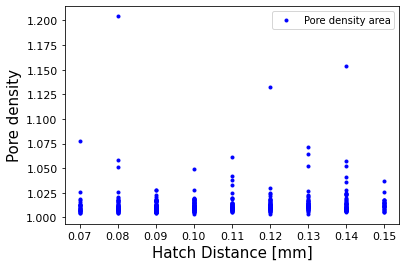

col Layer Thickness [mm]


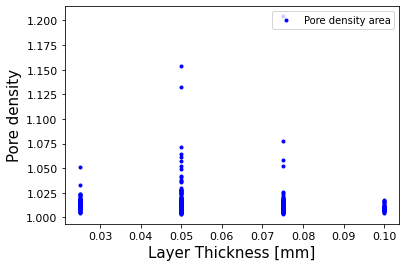

col VED [J/mm3]


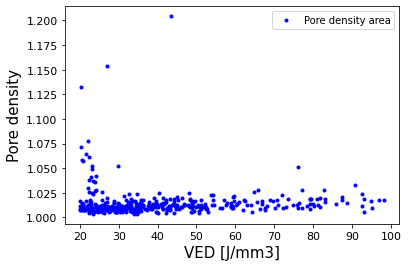

col TE [J/mm]


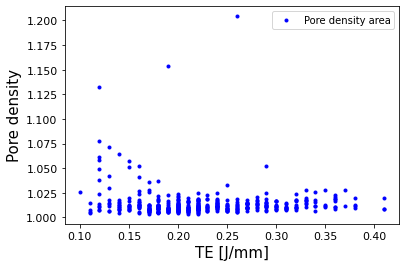

col Dichte [%] OTSU


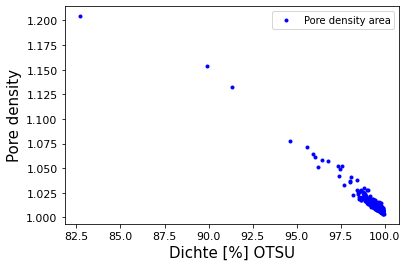

In [ ]:
## Plot pore area density (blue) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]

  pore_area_density = results['overall_pore_area_density']
  plt.plot(process_param, pore_area_density, '.b', label='Pore density area')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Pore density', fontsize=15)
  plt.legend(loc='upper right')


  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  #plt.savefig("/content/pore_density/pore_count_and_density_against_{}.jpg".format(col[0:5]))
  plt.show()



col Laser Power [W]


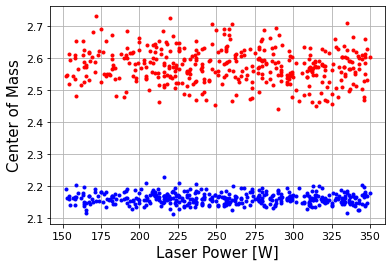

col Scan Speed [mm/s]


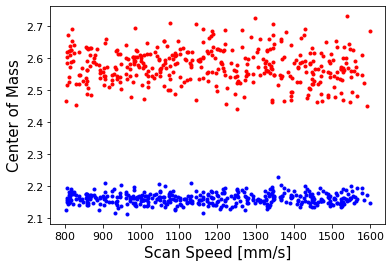

col Hatch Distance [mm]


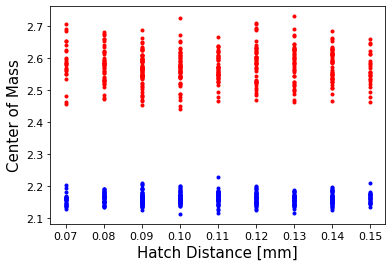

col Layer Thickness [mm]


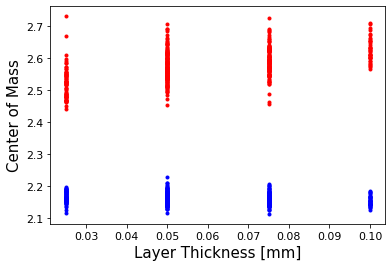

col VED [J/mm3]


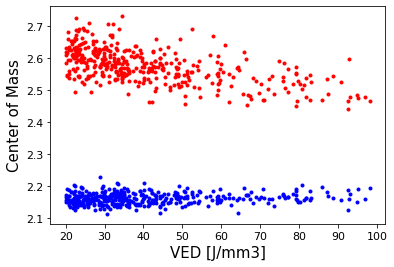

col TE [J/mm]


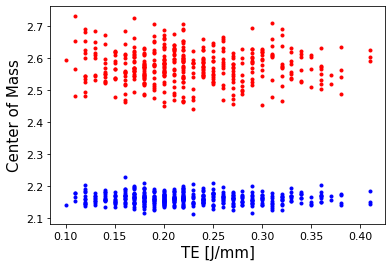

col Dichte [%] OTSU


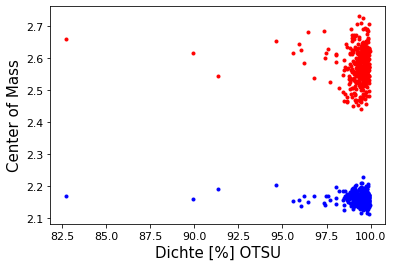

In [ ]:
## Plot center of the mass X  (red), Y (blue) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]
  mean_pore_com_x = results['mean_pore_com_x']
  plt.plot(process_param, mean_pore_com_x, '.r', label='pore_com_x')

  mean_pore_com_y = results['mean_pore_com_y']
  plt.plot(process_param, mean_pore_com_y, '.b', label='pore_com_y')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Center of Mass', fontsize=15)

  #plt.legend(loc='upper right')
  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  plt.savefig("/content/center_mass/center_of_mass_against_{}.jpg".format(col[0:5]))
  plt.show()



col Laser Power [W]


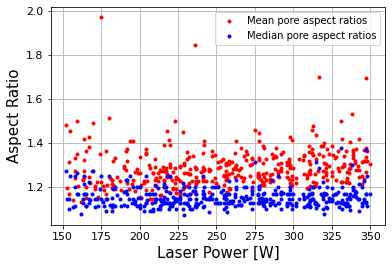

col Scan Speed [mm/s]


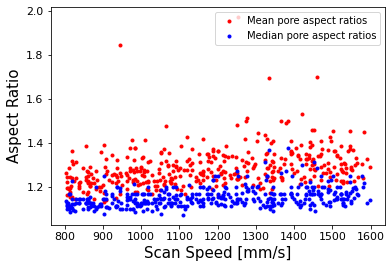

col Hatch Distance [mm]


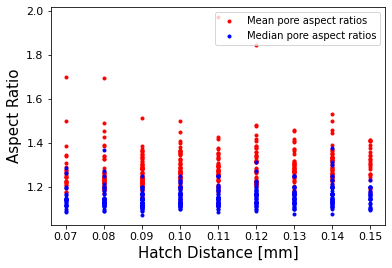

col Layer Thickness [mm]


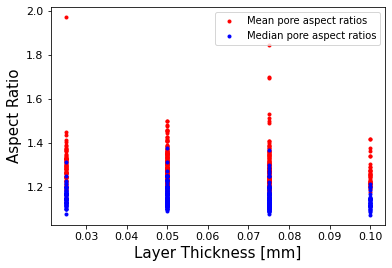

col VED [J/mm3]


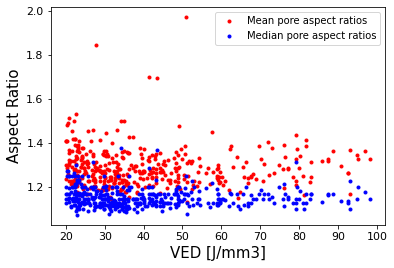

col TE [J/mm]


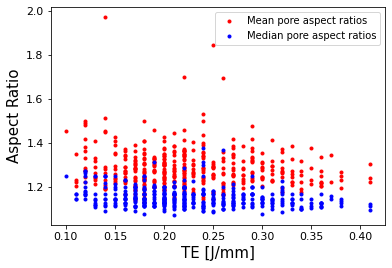

col Dichte [%] OTSU


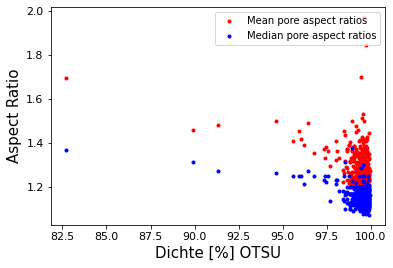

In [ ]:
## Plot aspect ratio mean (red) median (blue) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]
  mean_pore_aspect_ratios = results[ 'mean_pore_aspect_ratios']
  plt.plot(process_param, mean_pore_aspect_ratios, '.r', label='Mean pore aspect ratios')

  median_pore_aspect_ratios = results[ 'median_pore_aspect_ratios']
  plt.plot(process_param, median_pore_aspect_ratios, '.b', label='Median pore aspect ratios')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Aspect Ratio', fontsize=15)
  plt.legend(loc='upper right')

  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  #plt.savefig("/content/aspect_ratio_mean_median/aspect_ratio_against_{}.jpg".format(col[0:5]))
  plt.show()



col Laser Power [W]


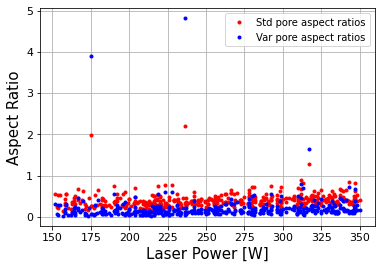

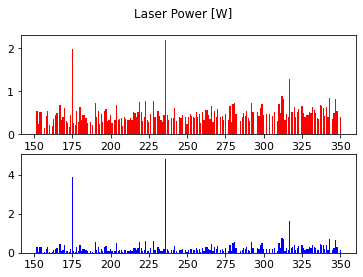

col Scan Speed [mm/s]


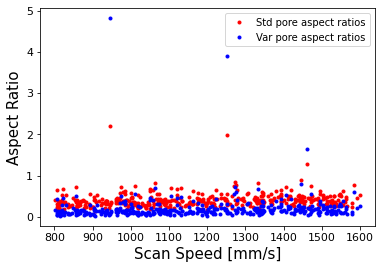

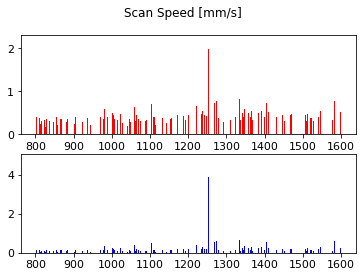

col Hatch Distance [mm]


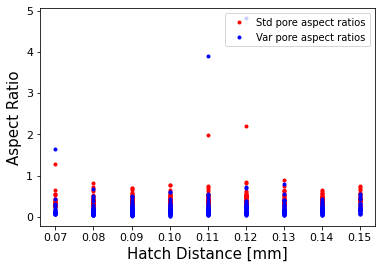

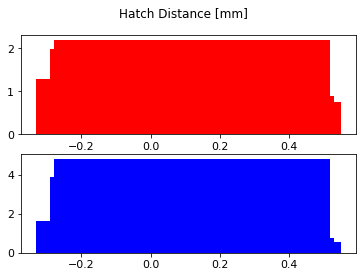

col Layer Thickness [mm]


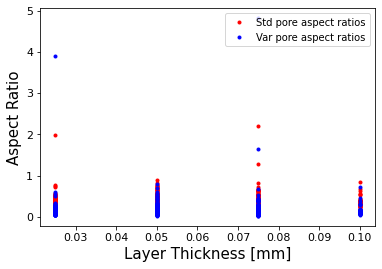

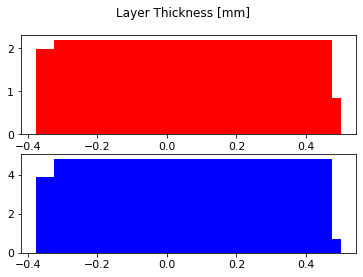

col VED [J/mm3]


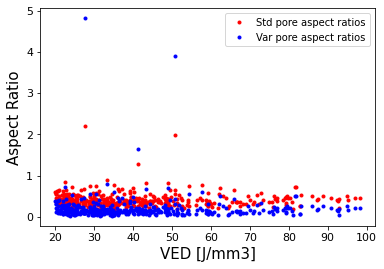

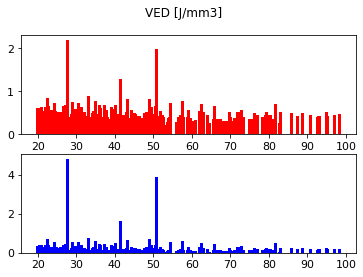

col TE [J/mm]


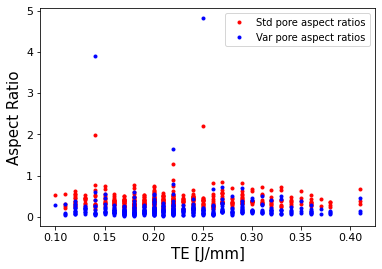

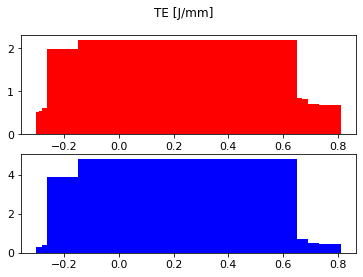

col Dichte [%] OTSU


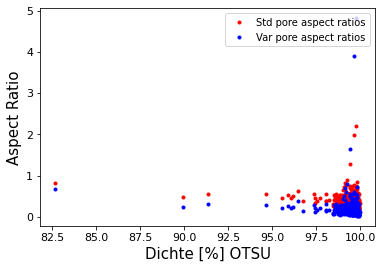

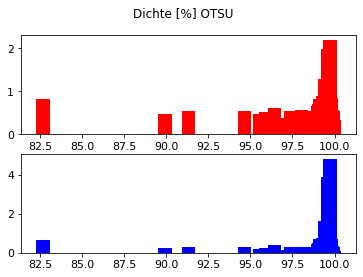

In [ ]:
## Plot aspect ratio sd (red) var (blue) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]
  std_pore_aspect_ratios = results[ 'std_pore_aspect_ratios']
  plt.plot(process_param, std_pore_aspect_ratios, '.r', label='Std pore aspect ratios')

  var_pore_aspect_ratios = results[ 'var_pore_aspect_ratios']
  plt.plot(process_param, var_pore_aspect_ratios, '.b', label='Var pore aspect ratios')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Aspect Ratio', fontsize=15)
  plt.legend(loc='upper right')

  #bar plot
  fig, axs = plt.subplots(2)
  plt.suptitle(col)
  axs[0].bar(process_param, std_pore_aspect_ratios, color='red')
  axs[1].bar(process_param, var_pore_aspect_ratios, color='blue')

  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  #plt.savefig("/content/aspect_ratio_var_std/aspect_ratio_against_{}.jpg".format(col[0:5]))
  plt.show()



col Laser Power [W]


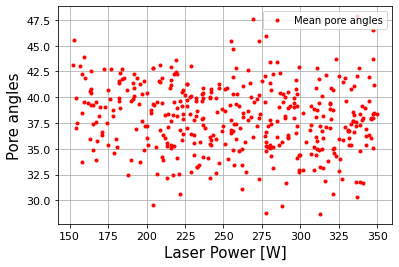

col Scan Speed [mm/s]


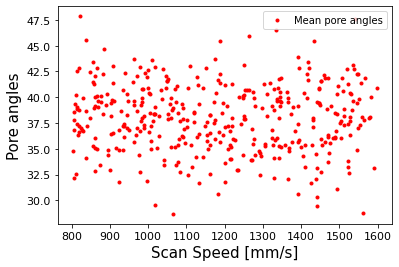

col Hatch Distance [mm]


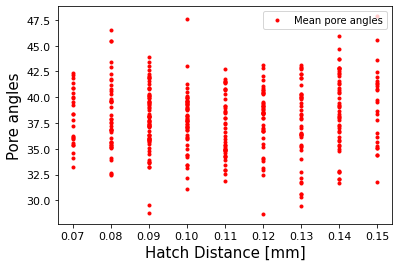

col Layer Thickness [mm]


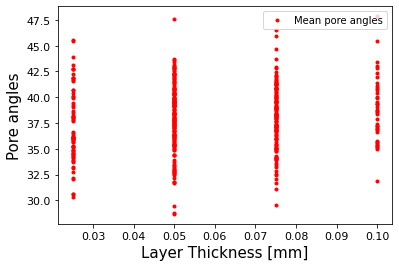

col VED [J/mm3]


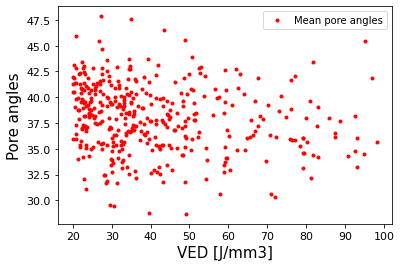

col TE [J/mm]


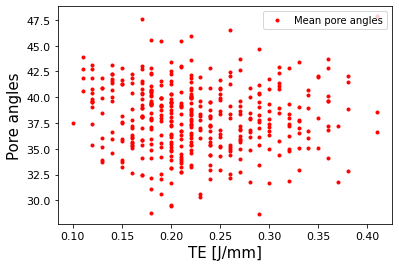

col Dichte [%] OTSU


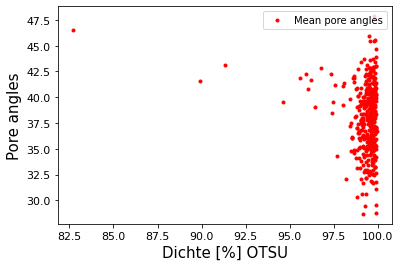

In [ ]:
## Plot pore angle mean (red) median (blue) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]
  mean_pore_angles = results['mean_pore_angles']
  plt.plot(process_param, mean_pore_angles, '.r', label='Mean pore angles')

  median_pore_angles = results[ 'median_pore_angles']
  #plt.plot(process_param, median_pore_angles, '.b', label='Median pore angles')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Pore angles', fontsize=15)
  plt.legend(loc='upper right')
  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  #plt.savefig("/content/Pore_angle_mean_median/pore_angle_against_{}.jpg".format(col[0:5]))
  plt.show()



col Laser Power [W]


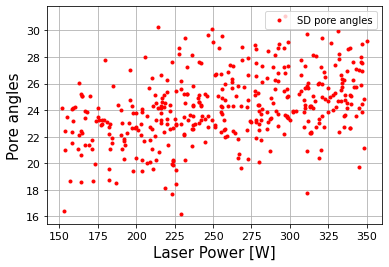

col Scan Speed [mm/s]


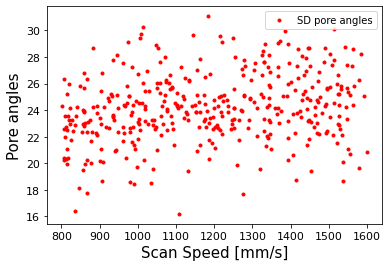

col Hatch Distance [mm]


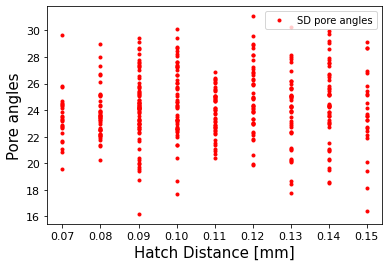

col Layer Thickness [mm]


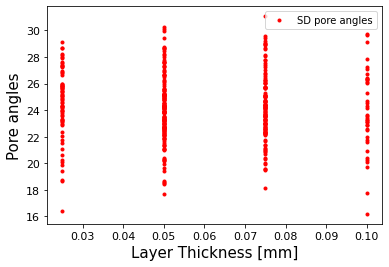

col VED [J/mm3]


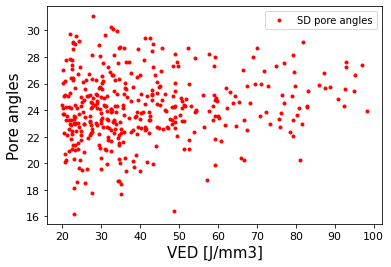

col TE [J/mm]


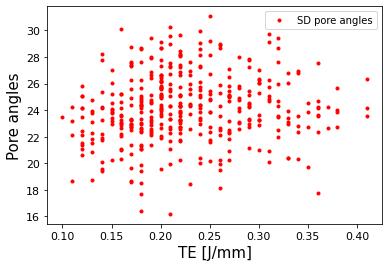

col Dichte [%] OTSU


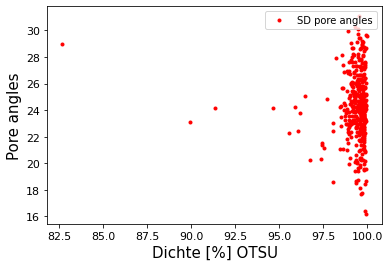

In [ ]:
## Plot pore angle std (red) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]
  std_pore_angles = results['std_pore_angles']
  plt.plot(process_param, std_pore_angles, '.r', label='SD pore angles')


  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Pore angles', fontsize=15)
  plt.legend(loc='upper right')
  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  #plt.savefig("/content/pore_angle_sd_var/pore_angle_sd_var_against_{}.jpg".format(col[0:5]))
  plt.show()



col Laser Power [W]


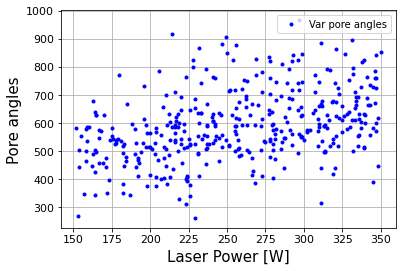

col Scan Speed [mm/s]


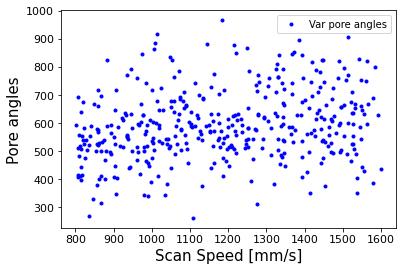

col Hatch Distance [mm]


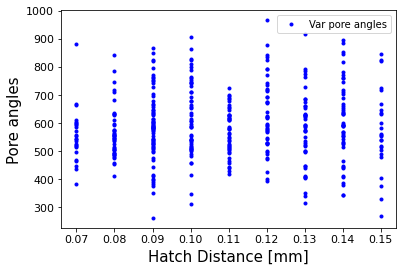

col Layer Thickness [mm]


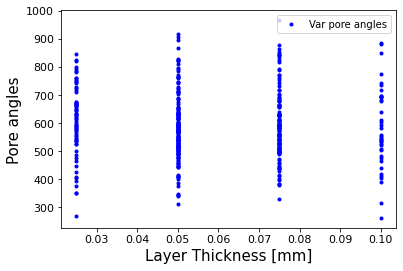

col VED [J/mm3]


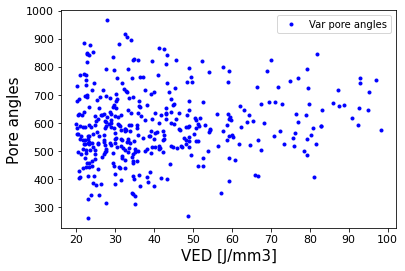

col TE [J/mm]


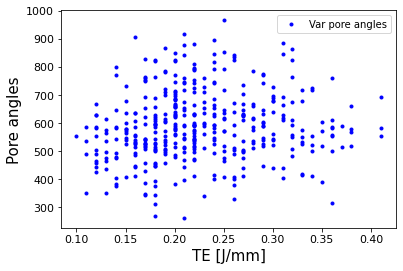

col Dichte [%] OTSU


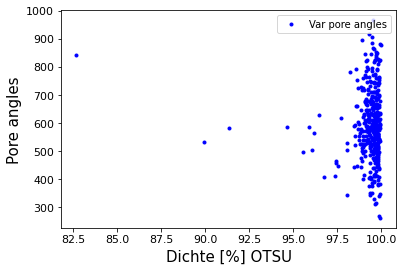

In [ ]:
## Plot pore angle var (blue) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]

  var_pore_angles = results[ 'var_pore_angles']
  plt.plot(process_param, var_pore_angles, '.b', label='Var pore angles')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Pore angles', fontsize=15)
  plt.legend(loc='upper right')
  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  #plt.savefig("/content/pore_angle_sd_var/pore_angle_sd_var_against_{}.jpg".format(col[0:5]))
  plt.show()



col Laser Power [W]


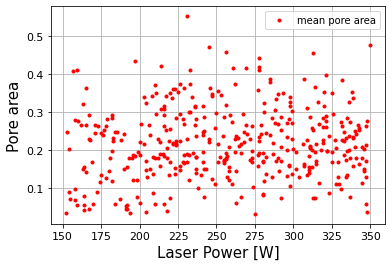

col Scan Speed [mm/s]


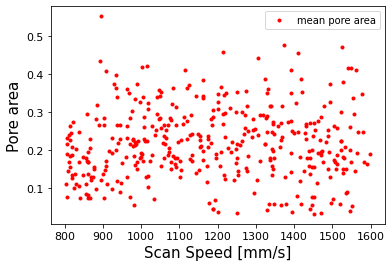

col Hatch Distance [mm]


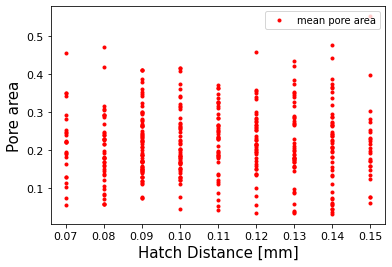

col Layer Thickness [mm]


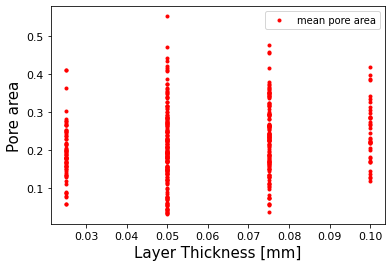

col VED [J/mm3]


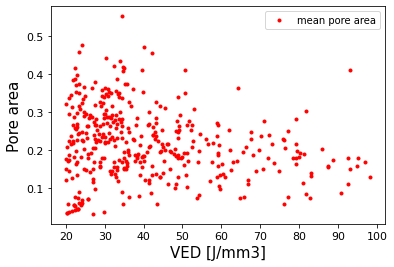

col TE [J/mm]


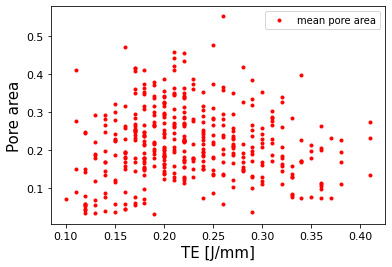

col Dichte [%] OTSU


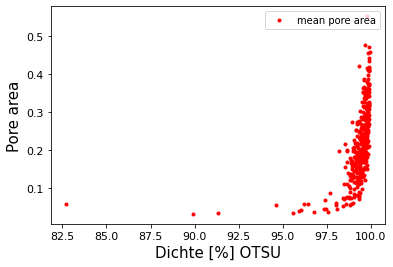

In [ ]:
## Plot pore area mean (red) median (blue) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]
  mean_pore_area = results['mean_pore_area']
  plt.plot(process_param, mean_pore_area, '.r', label='mean pore area')

  # median_pore_area = results[ 'median_pore_area']
  # plt.plot(process_param, median_pore_area, '.b', label='median pore area')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Pore area', fontsize=15)
  plt.legend(loc='upper right')
  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  #plt.savefig("/content/pore_area_mean/pore_area_mean_against_{}.jpg".format(col[0:5]))
  plt.show()



col Laser Power [W]


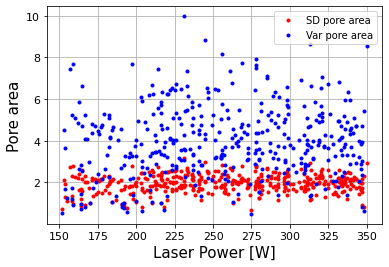

col Scan Speed [mm/s]


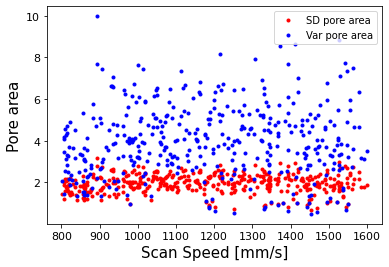

col Hatch Distance [mm]


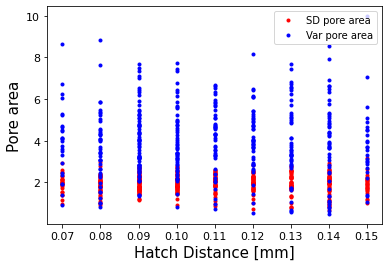

col Layer Thickness [mm]


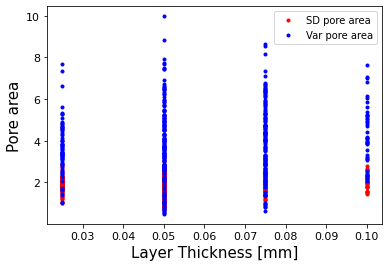

col VED [J/mm3]


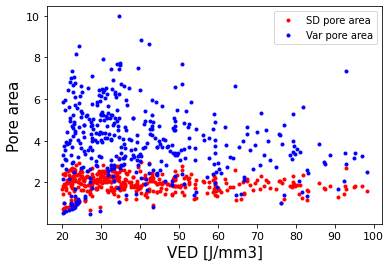

col TE [J/mm]


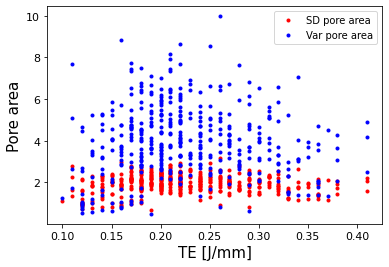

col Dichte [%] OTSU


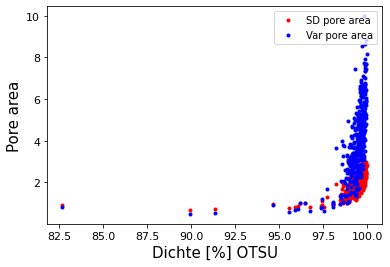

In [ ]:
## Plot pore area sd (red) var (blue) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]
  std_pore_area = results['std_pore_area']
  plt.plot(process_param, std_pore_area, '.r', label='SD pore area')

  var_pore_area = results[ 'var_pore_area']
  plt.plot(process_param, var_pore_area, '.b', label='Var pore area')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Pore area', fontsize=15)
  plt.legend(loc='upper right')
  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  #plt.savefig("/content/pore_area_sd_var/pore_area_std_var_against_{}.jpg".format(col[0:5]))
  plt.show()



col Laser Power [W]


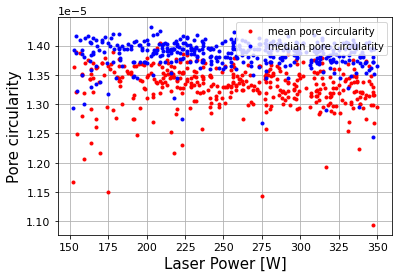

col Scan Speed [mm/s]


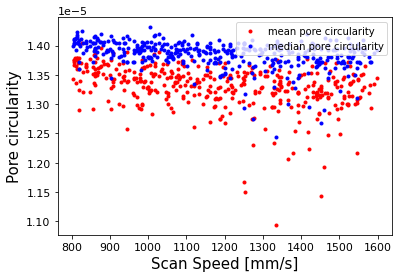

col Hatch Distance [mm]


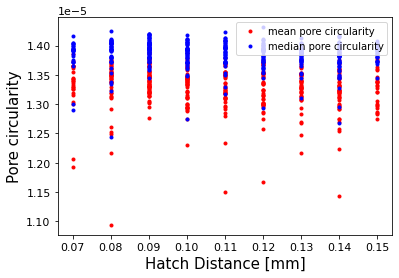

col Layer Thickness [mm]


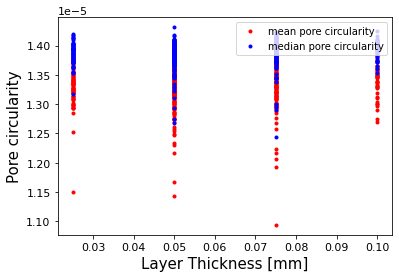

col VED [J/mm3]


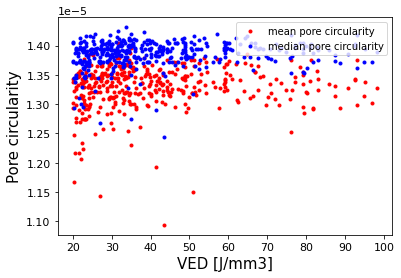

col TE [J/mm]


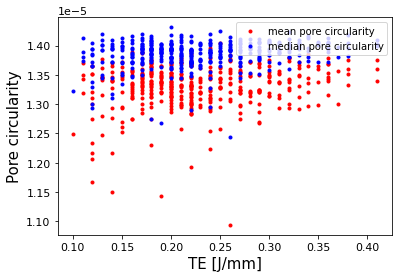

col Dichte [%] OTSU


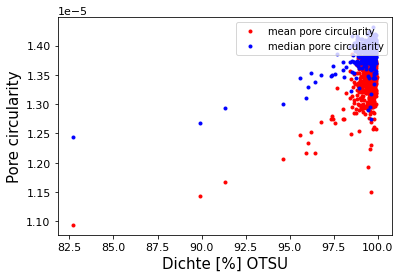

In [ ]:
## Plot pore circularity mean (red) median (blue) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]
  mean_circularity = results['mean_circularity']
  plt.plot(process_param, mean_circularity, '.r', label='mean pore circularity')

  median_circularity = results[ 'median_circularity']
  plt.plot(process_param, median_circularity, '.b', label='median pore circularity')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Pore circularity', fontsize=15)
  plt.legend(loc='upper right')
  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  #plt.savefig("/content/pore_circularity_mean_medain/pore_circularity_mean_median_against_{}.jpg".format(col[0:5]))
  plt.show()

col Laser Power [W]


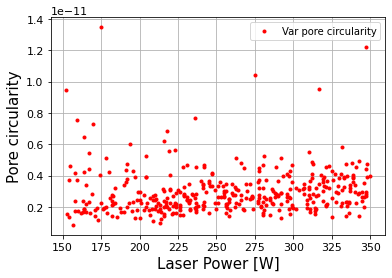

col Scan Speed [mm/s]


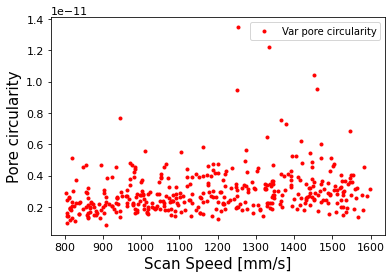

col Hatch Distance [mm]


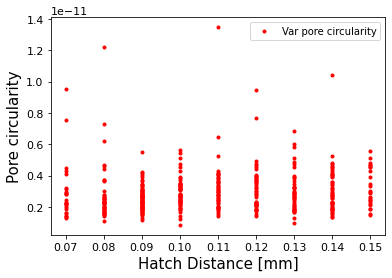

col Layer Thickness [mm]


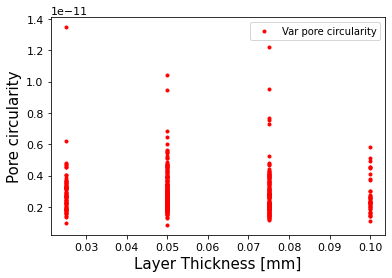

col VED [J/mm3]


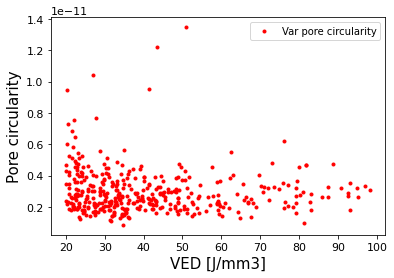

col TE [J/mm]


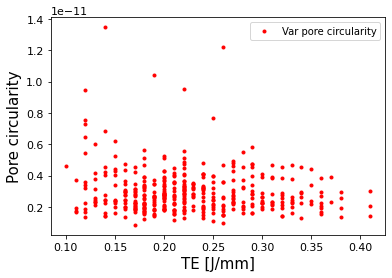

col Dichte [%] OTSU


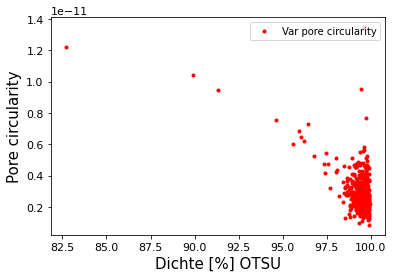

In [ ]:
## Plot pore circularity var (red) std (blue) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]
  var_circularity = results['var_circularity']
  plt.plot(process_param, var_circularity, '.r', label='Var pore circularity')

  std_circularity = results[ 'std_circularity']
  #plt.plot(process_param, std_circularity, '.b', label='SD pore circularity')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Pore circularity', fontsize=15)
  plt.legend(loc='upper right')
  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  #plt.savefig("/content/pore_circularity_Var_sd/pore_circularity_var_sd_against_{}.jpg".format(col[0:5]))
  plt.show()

col Laser Power [W]


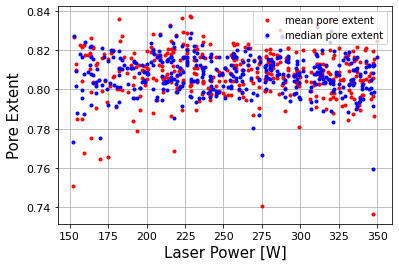

col Scan Speed [mm/s]


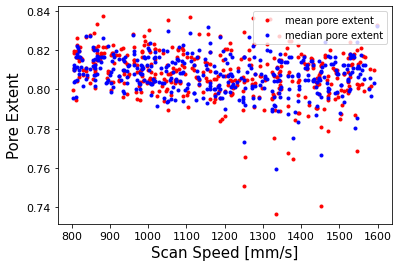

col Hatch Distance [mm]


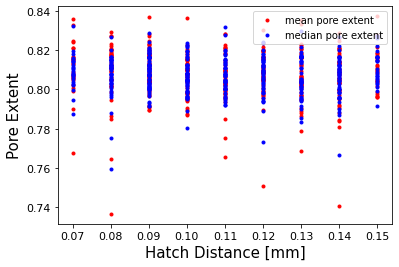

col Layer Thickness [mm]


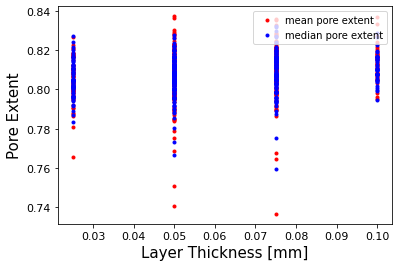

col VED [J/mm3]


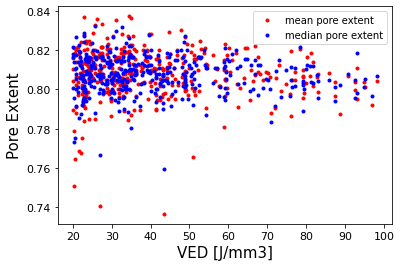

col TE [J/mm]


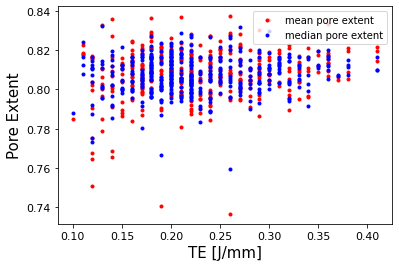

col Dichte [%] OTSU


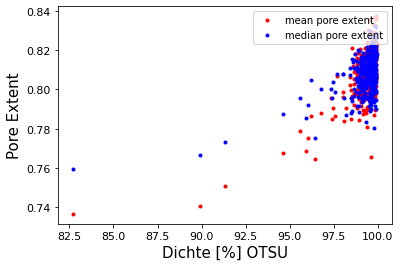

In [ ]:
## Plot pore extent mean (red) median (blue) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]
  mean_extent = results['mean_extent']
  plt.plot(process_param, mean_extent, '.r', label='mean pore extent')

  median_extent = results[ 'median_extent']
  plt.plot(process_param, median_extent, '.b', label='median pore extent')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Pore Extent', fontsize=15)
  plt.legend(loc='upper right')
  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  #plt.savefig("/content/pore_extent_mean_medain/pore_extent_mean_median_against_{}.jpg".format(col[0:5]))
  plt.show()

col Laser Power [W]


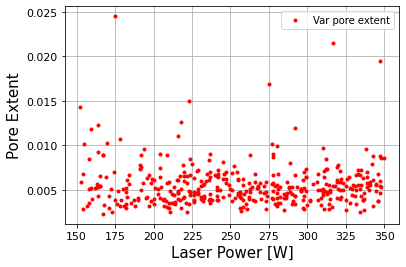

col Scan Speed [mm/s]


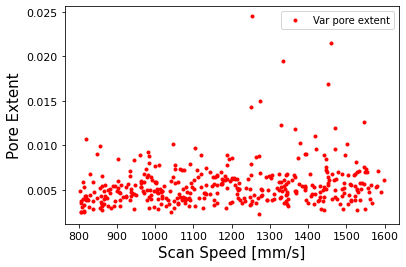

col Hatch Distance [mm]


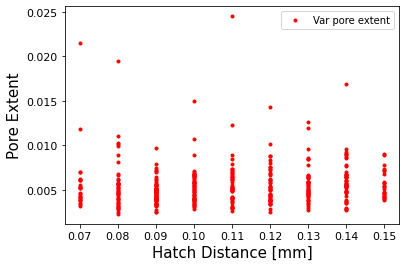

col Layer Thickness [mm]


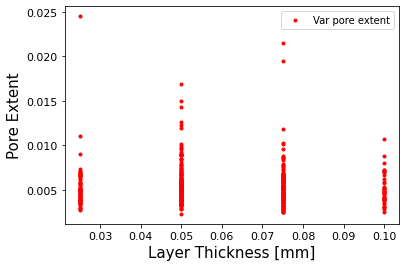

col VED [J/mm3]


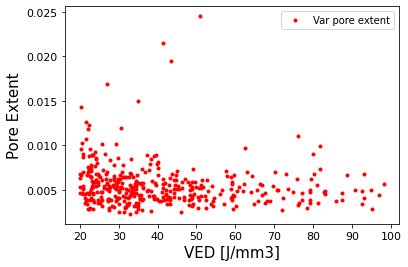

col TE [J/mm]


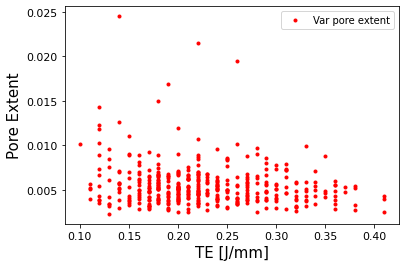

col Dichte [%] OTSU


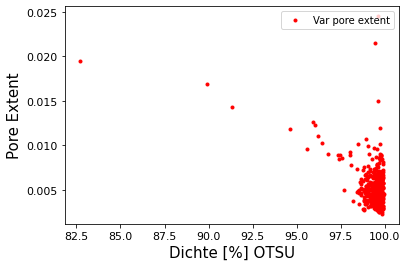

In [ ]:
## Plot pore extent var (red) sd (blue) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]
  var_extent = results['var_extent']
  plt.plot(process_param, var_extent, '.r', label='Var pore extent')

  std_extent = results[ 'std_extent']
  #plt.plot(process_param, std_extent, '.b', label='SD pore extent')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Pore Extent', fontsize=15)
  plt.legend(loc='upper right')
  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  #plt.savefig("/content/pore_extent_var_sd/pore_extent_var_sd_against_{}.jpg".format(col[0:5]))
  plt.show()

col Laser Power [W]


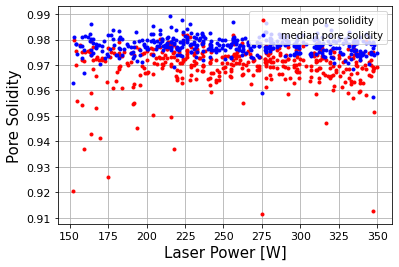

col Scan Speed [mm/s]


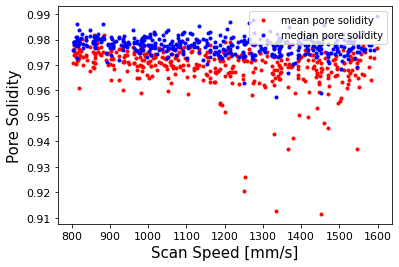

col Hatch Distance [mm]


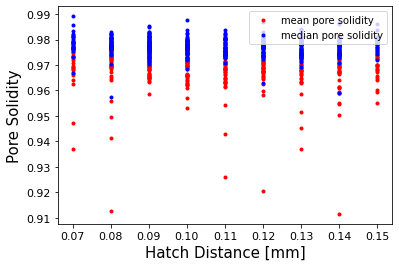

col Layer Thickness [mm]


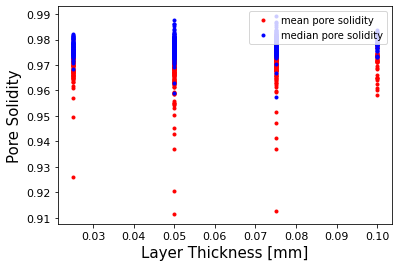

col VED [J/mm3]


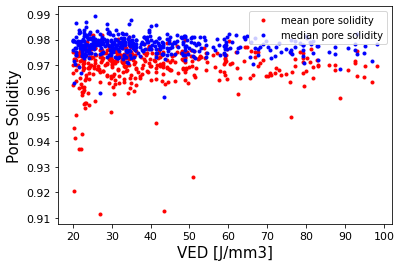

col TE [J/mm]


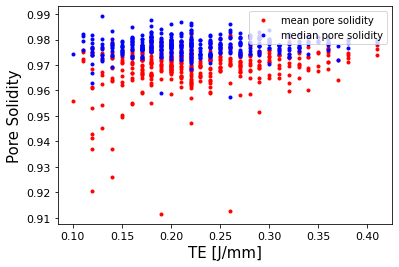

col Dichte [%] OTSU


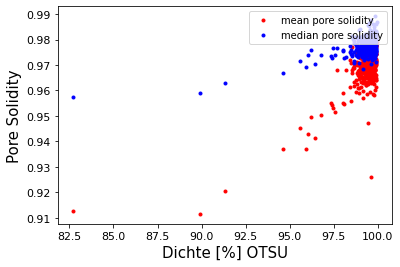

In [ ]:
## Plot pore solidity mean (red) median (blue) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]
  mean_solidity = results['mean_solidity']
  plt.plot(process_param, mean_solidity, '.r', label='mean pore solidity')

  median_solidity = results[ 'median_solidity']
  plt.plot(process_param, median_solidity, '.b', label='median pore solidity')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Pore Solidity', fontsize=15)
  plt.legend(loc='upper right')
  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  plt.savefig("/content/pore_solidity_mean_medain/pore_solidity_mean_median_against_{}.jpg".format(col[0:5]))
  plt.show()

col Laser Power [W]


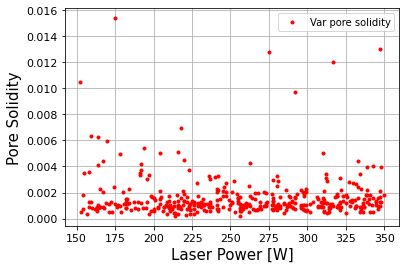

col Scan Speed [mm/s]


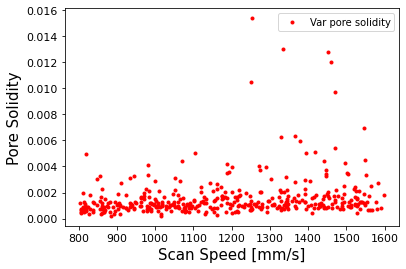

col Hatch Distance [mm]


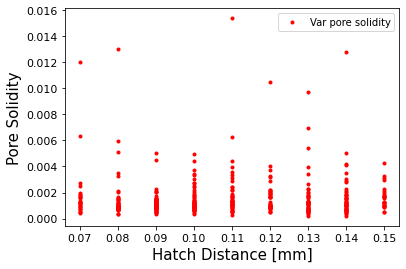

col Layer Thickness [mm]


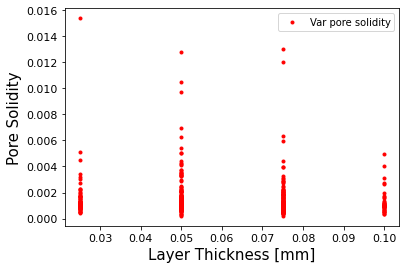

col VED [J/mm3]


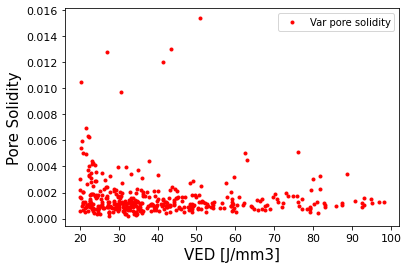

col TE [J/mm]


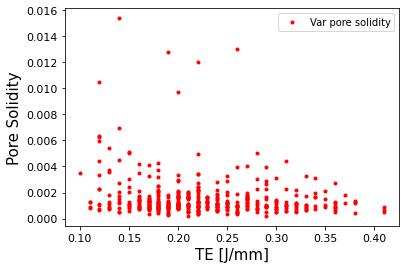

col Dichte [%] OTSU


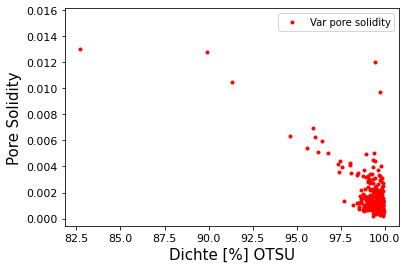

In [ ]:
## Plot pore solidity Var (red) SD (blue) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]
  var_solidity = results['var_solidity']
  plt.plot(process_param, var_solidity, '.r', label='Var pore solidity')

  std_solidity = results[ 'std_solidity']
 # plt.plot(process_param, std_solidity, '.b', label='SD pore solidity')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Pore Solidity', fontsize=15)
  plt.legend(loc='upper right')
  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  #plt.savefig("/content/pore_solidity_var_sd/pore_solidity_Var_sd_against_{}.jpg".format(col[0:5]))
  plt.show()

col Laser Power [W]


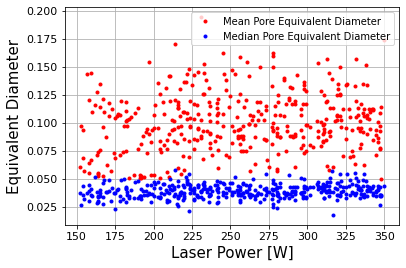

col Scan Speed [mm/s]


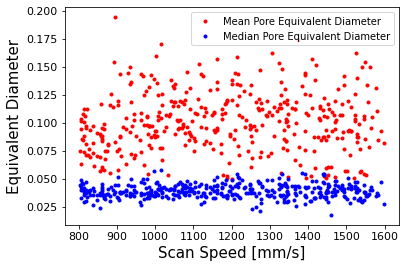

col Hatch Distance [mm]


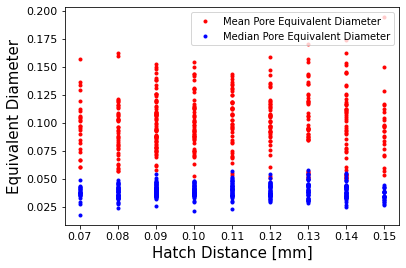

col Layer Thickness [mm]


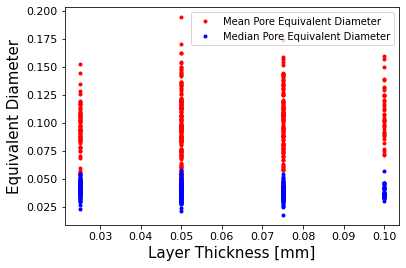

col VED [J/mm3]


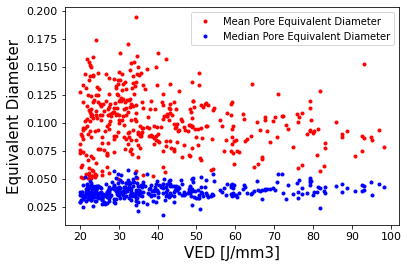

col TE [J/mm]


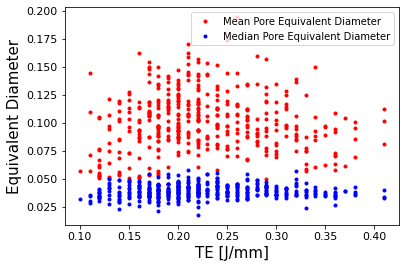

col Dichte [%] OTSU


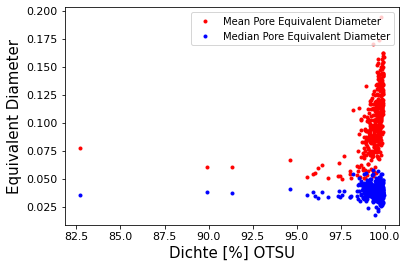

In [ ]:
## Plot pore Equivalent Diameter mean (red) median (blue) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]
  mean_equi_diameter = results['mean_equi_diameter']
  plt.plot(process_param, mean_equi_diameter, '.r', label='Mean Pore Equivalent Diameter')

  median_equi_diameter = results[ 'median_equi_diameter']
  plt.plot(process_param, median_equi_diameter, '.b', label='Median Pore Equivalent Diameter')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Equivalent Diameter', fontsize=15)
  plt.legend(loc='upper right')
  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  plt.savefig("/content/pore_equi_diameter_mean_medain/pore_equi_diameter_mean_median_against_{}.jpg".format(col[0:5]))
  plt.show()

col Laser Power [W]


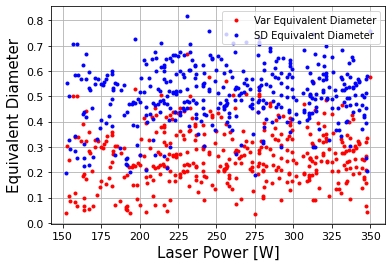

col Scan Speed [mm/s]


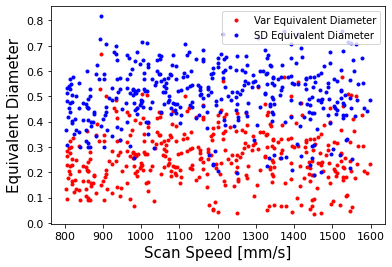

col Hatch Distance [mm]


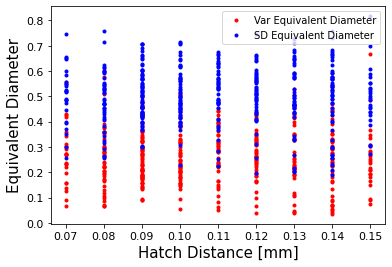

col Layer Thickness [mm]


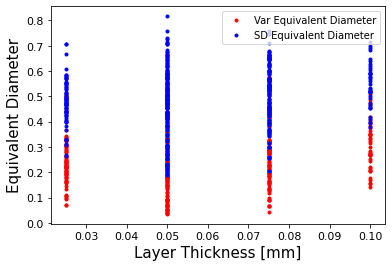

col VED [J/mm3]


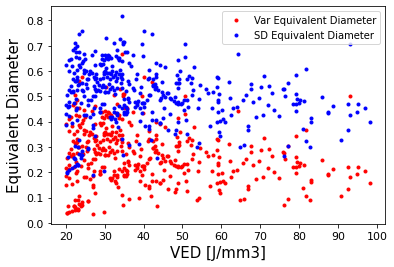

col TE [J/mm]


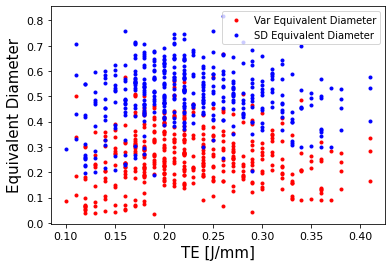

col Dichte [%] OTSU


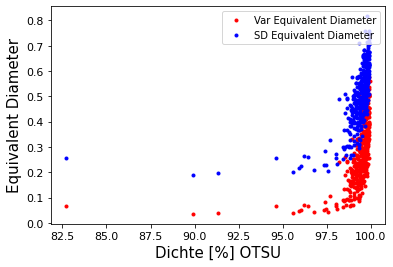

In [ ]:
## Plot pore Equivalent Diameter Var (red) SD (blue) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]
  var_equi_diameter = results['var_equi_diameter']
  plt.plot(process_param, var_equi_diameter, '.r', label='Var Equivalent Diameter')

  std_equi_diameter = results[ 'std_equi_diameter']
  plt.plot(process_param, std_equi_diameter, '.b', label='SD Equivalent Diameter')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Equivalent Diameter', fontsize=15)
  plt.legend(loc='upper right')
  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  #plt.savefig("/content/pore_equi_diameter_Var_sd/pore_equi_diameter_Var_sd_against_{}.jpg".format(col[0:5]))
  plt.show()

In [ ]:
from google.colab import files
!zip -r /content/data_images.zip /content/data_images
#files.download('/content/??.zip')

col Laser Power [W]


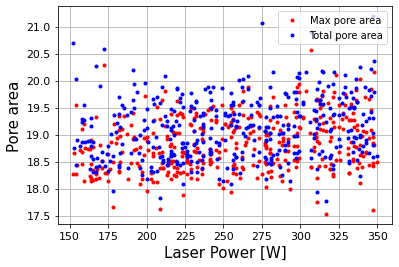

col Scan Speed [mm/s]


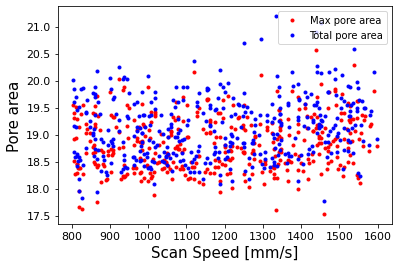

col Hatch Distance [mm]


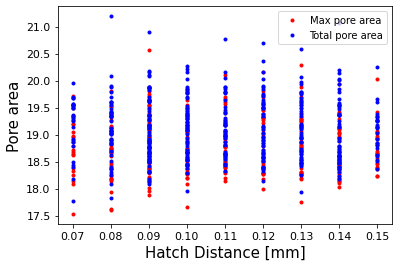

col Layer Thickness [mm]


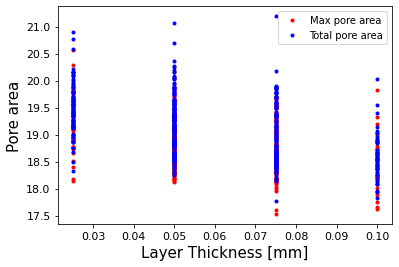

col VED [J/mm3]


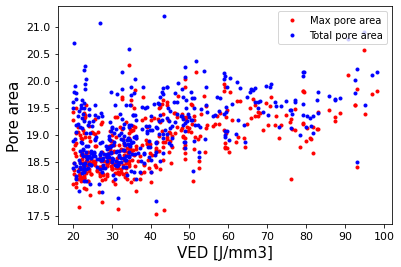

col TE [J/mm]


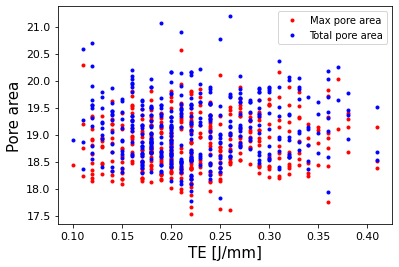

col Dichte [%] OTSU


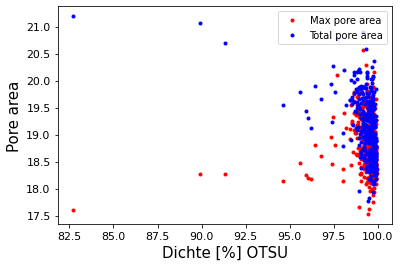

In [ ]:
## Plot pore area max (red) total (blue) against the process ameters

import matplotlib.pyplot as plt

plt.figure(1)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
#plt.title('Title', fontsize=15)
plt.grid(True)

results = pd.read_csv("/content/merged_result.csv")
columns =['Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']

for col in columns:
  print('col',col)
  process_param= results[col]
  max_pore_area = results['max_pore_area']
  plt.plot(process_param, max_pore_area, '.r', label='Max pore area')

  total_pore_area = results[ 'total_pore_area']
  plt.plot(process_param, total_pore_area, '.b', label='Total pore area')

  #plt.ylim([2, 2.9])
  #plt.xlim([0, 4])

  plt.xlabel(col, fontsize=15)
  plt.ylabel('Pore area', fontsize=15)
  plt.legend(loc='upper right')
  #plt.legend(loc='center')
  #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', borderaxespad=0)

  #plt.savefig("/content/pore_area/pore_area_max_total_against_{}.jpg".format(col[0:5]))
  plt.show()



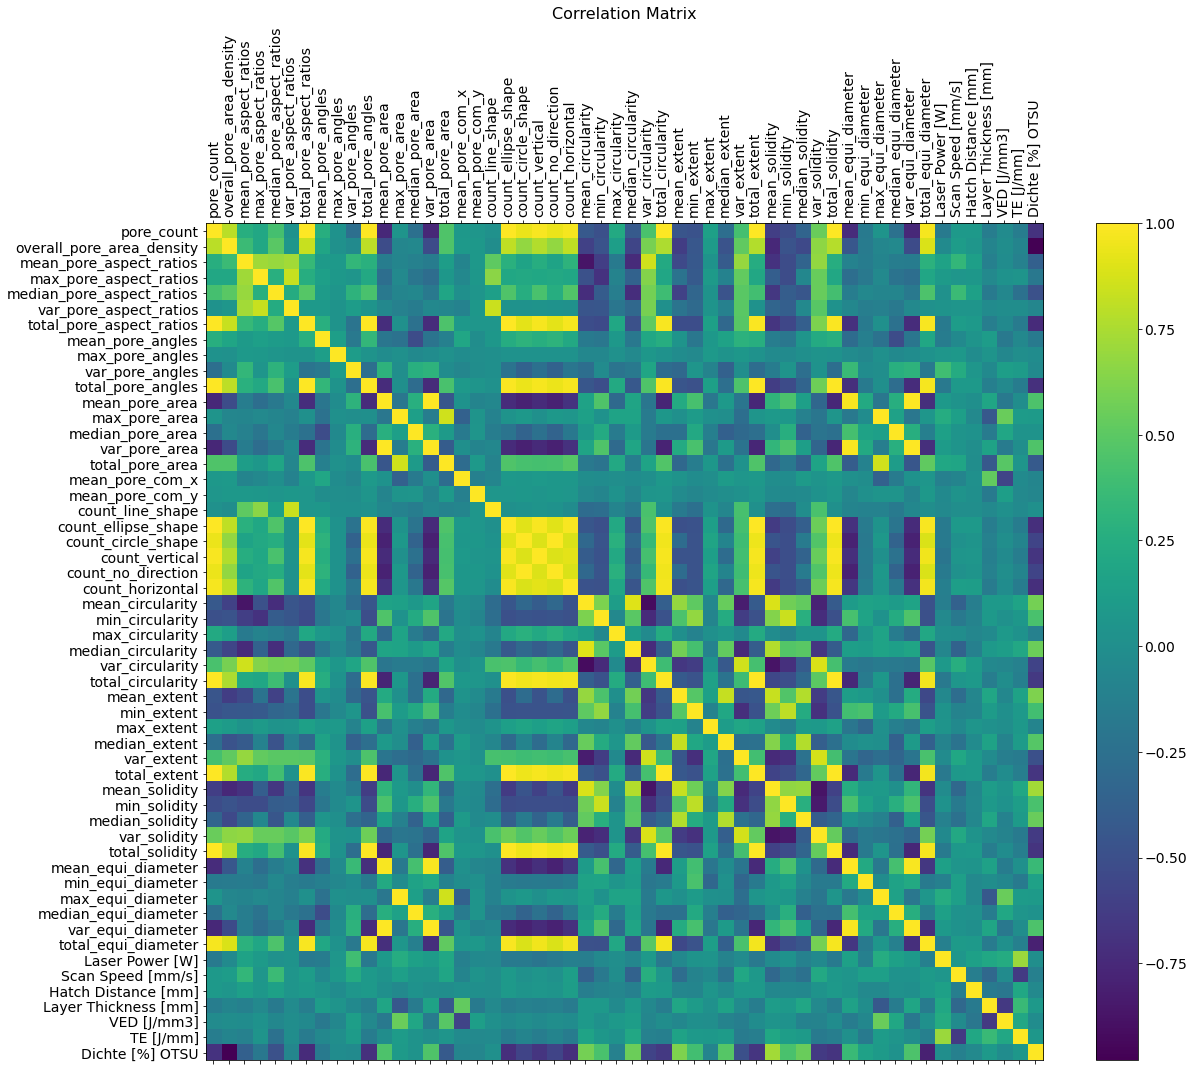

In [ ]:
#corr(method='pearson')

df1 = pd.read_csv("/content/merged_result.csv")
df=df1.drop(['Index/Bildnummer', 'min_pore_aspect_ratios', 'min_pore_angles', 'min_pore_area'
,'max_solidity', 'median_pore_angles', 'std_pore_aspect_ratios','std_pore_angles','std_pore_area',
'std_circularity', 'std_extent', 'std_solidity', 'std_equi_diameter'], axis=1)
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(method='pearson'), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
#plt.savefig("/content/features_correlation.jpg")



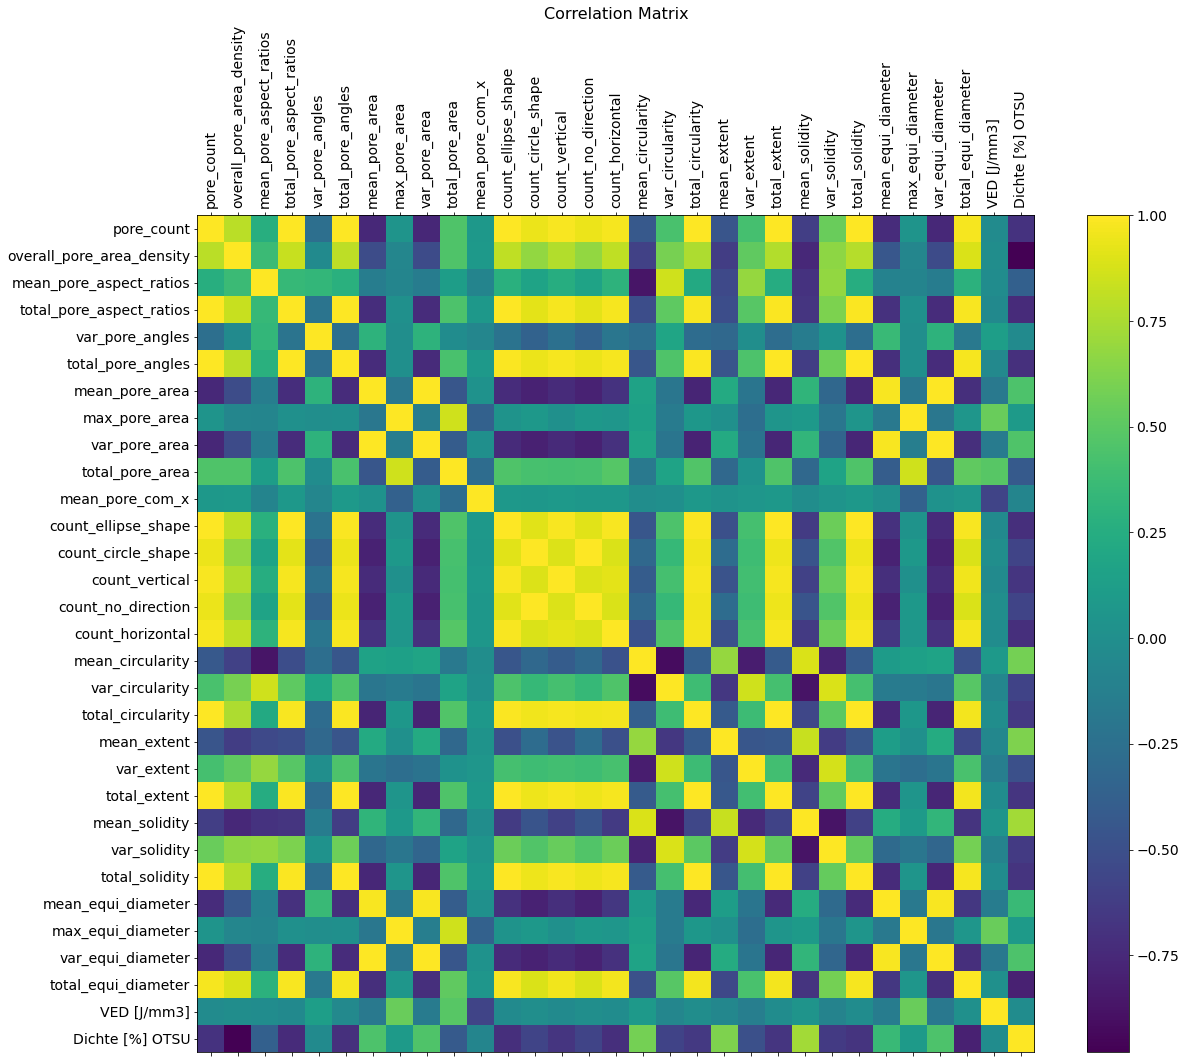

In [ ]:
#corr(method='pearson')

df1 = pd.read_csv("/content/merged_result.csv")
df=df1.drop(['Index/Bildnummer', 'min_pore_aspect_ratios', 'min_pore_angles', 'min_pore_area'
,'max_solidity', 'median_pore_angles', 'std_pore_aspect_ratios','std_pore_angles','std_pore_area',
'std_circularity', 'std_extent', 'std_solidity', 'std_equi_diameter','max_pore_angles', 'mean_pore_com_y','TE [J/mm]','Laser Power [W]', 'Scan Speed [mm/s]','Hatch Distance [mm]','min_equi_diameter', 
'Layer Thickness [mm]','mean_pore_angles','min_circularity', 'max_circularity', 'min_extent','max_extent','max_pore_aspect_ratios', 'median_pore_aspect_ratios','var_pore_aspect_ratios', 'count_line_shape',
'min_solidity', 'max_solidity', 'median_solidity', 'median_pore_area',  'median_circularity', 'median_extent','median_equi_diameter'], axis=1)
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(method='pearson'), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
#plt.savefig("/content/strong_features_correlation.jpg")

In [ ]:
#corr(method='pearson')

df1 = pd.read_csv("/content/merged_result.csv")
df2=df1[["min_pore_aspect_ratios", "min_pore_area"]]
df3=df1[["std_equi_diameter", "std_pore_angles"]]

# f = plt.figure(figsize=(19, 15))
# plt.matshow(df.corr(method='pearson'), fignum=f.number)
# plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
# plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
# cb = plt.colorbar()
# cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16);
# #plt.savefig("/content/features_correlation.jpg")

df2.corrwith(df3)

min_pore_area            NaN
min_pore_aspect_ratios   NaN
std_equi_diameter        NaN
std_pore_angles          NaN
dtype: float64

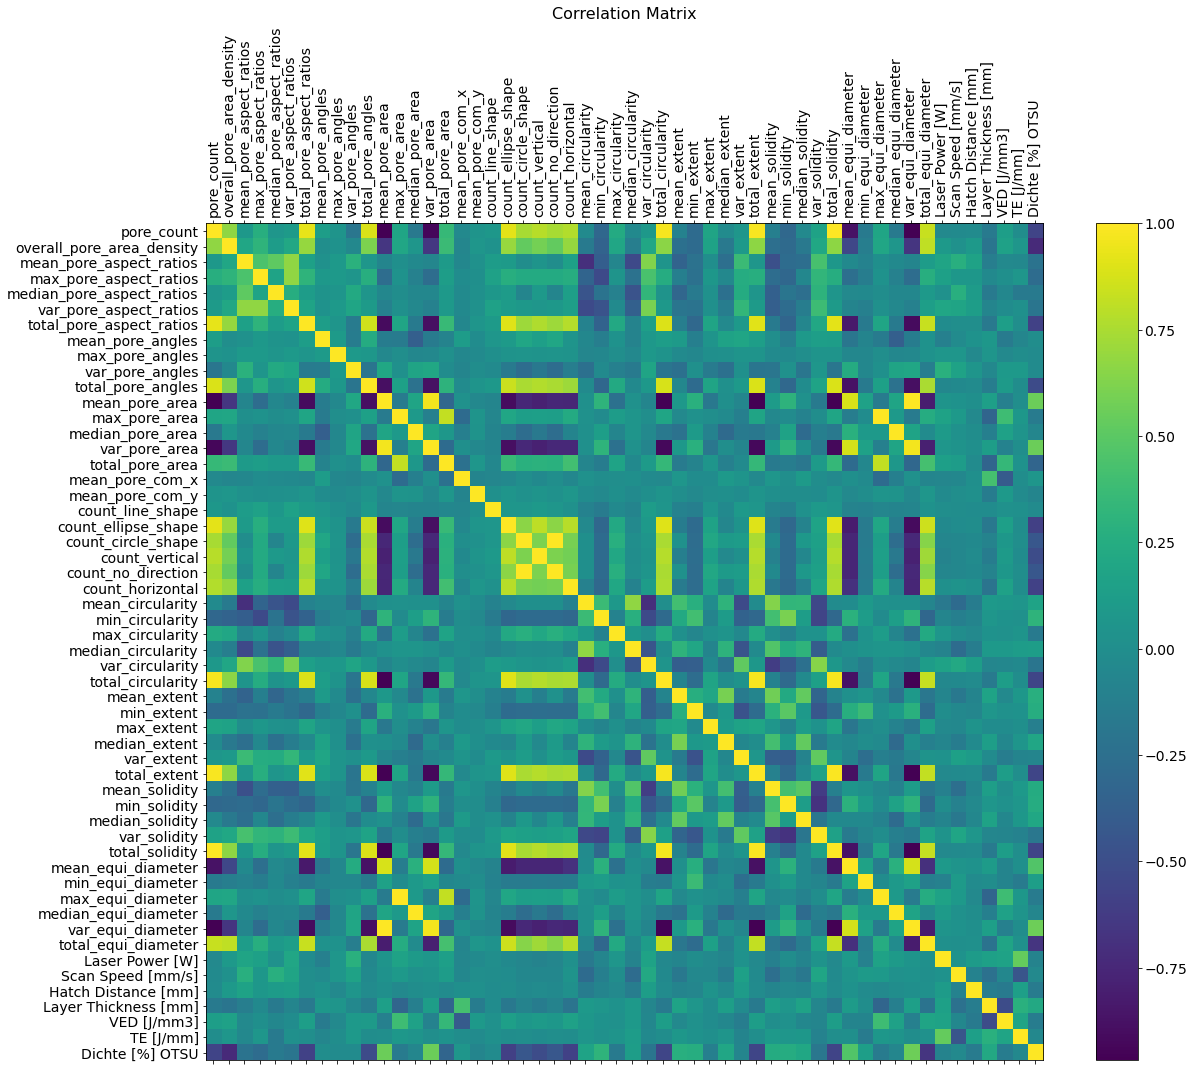

In [ ]:
#corr(method='kendall')

df1 = pd.read_csv("/content/merged_result.csv")
df=df1.drop(['Index/Bildnummer', 'min_pore_aspect_ratios', 'min_pore_angles', 'min_pore_area'
,'max_solidity', 'median_pore_angles', 'std_pore_aspect_ratios','std_pore_angles','std_pore_area',
'std_circularity', 'std_extent', 'std_solidity', 'std_equi_diameter'], axis=1)
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(method='kendall'), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
#plt.savefig("/content/features_correlation.jpg")

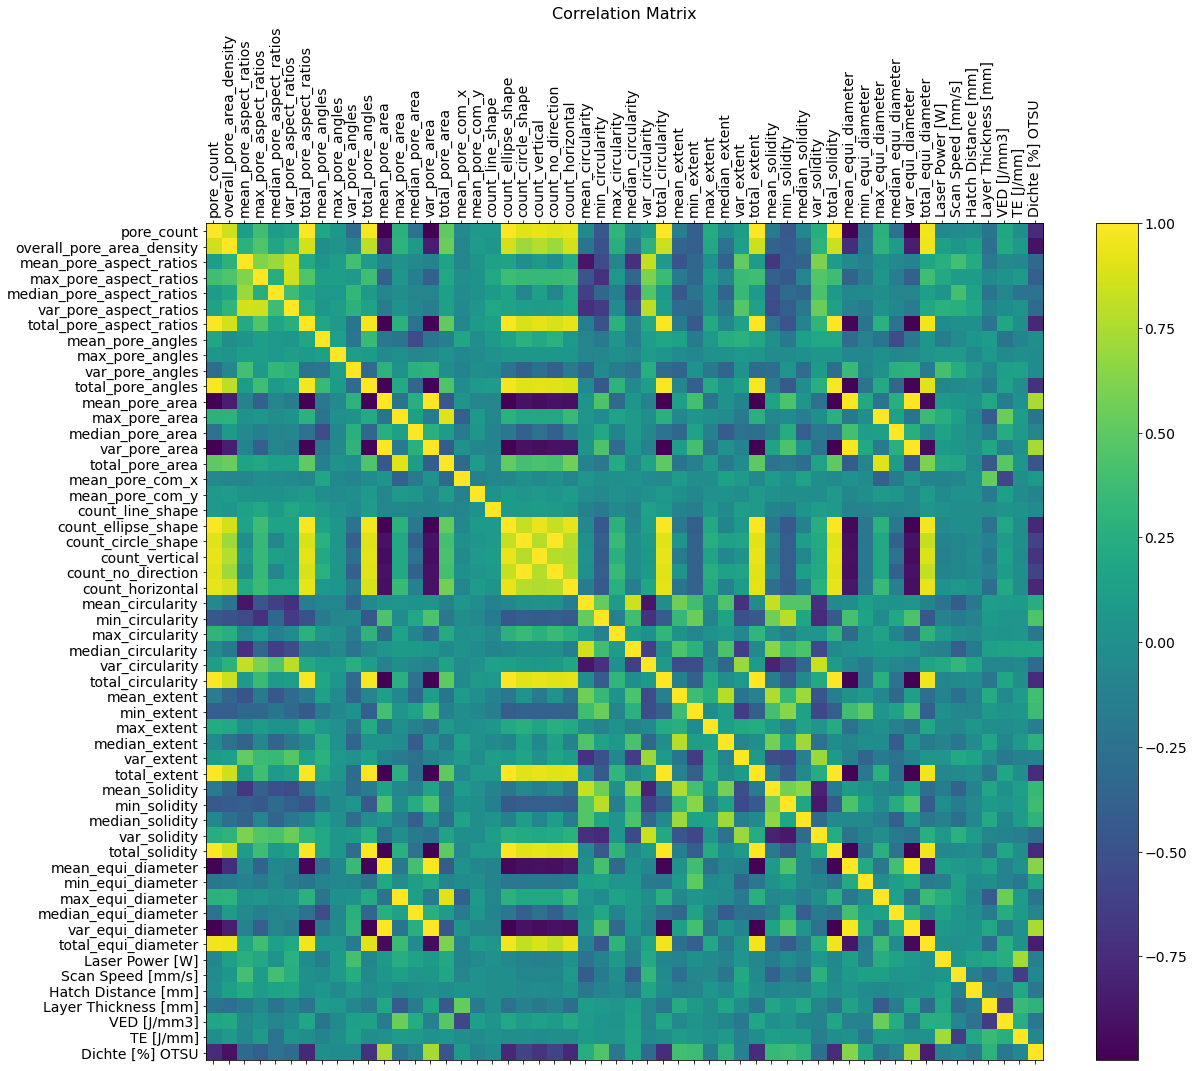

In [ ]:
#corr(method='spearman')

df1 = pd.read_csv("/content/merged_result.csv")
df=df1.drop(['Index/Bildnummer', 'min_pore_aspect_ratios', 'min_pore_angles', 'min_pore_area'
,'max_solidity', 'median_pore_angles', 'std_pore_aspect_ratios','std_pore_angles','std_pore_area',
'std_circularity', 'std_extent', 'std_solidity', 'std_equi_diameter'], axis=1)
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(method='spearman'), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
#plt.savefig("/content/features_correlation.jpg")



In [ ]:
## visulizing the features:
import matplotlib.pyplot as plt
import sys
import glob
sys.path.append('../')
import numpy as np
import datetime
import pandas as pd
from matplotlib.pyplot import figure
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import argparse
sys.path.append('../')

statistictics_over_all_images = pd.read_csv("/content/merged_result.csv")

columns =[ 'Laser Power [W]', 'Scan Speed [mm/s]', 'Hatch Distance [mm]', 'Layer Thickness [mm]', 'VED [J/mm3]', 'TE [J/mm]', 'Dichte [%] OTSU']


for col in columns:

  #mode='lines+markers'
  fig = make_subplots(rows=7, cols=1, shared_xaxes=True, vertical_spacing=0.1)
  fig.append_trace(go.Scatter(x=statistictics_over_all_images[col], y=statistictics_over_all_images['mean_pore_com_x'], name="Pore com X", mode='markers', marker=dict(size=4, color='green')),row=1, col=1)
  fig.append_trace(go.Scatter(x=statistictics_over_all_images[col], y=statistictics_over_all_images['mean_pore_com_y'], name="Pore com Y", mode='markers', marker=dict(size=4, color='green')),row=2, col=1)
  # Update layout and axes of the plot
  title = "Some features extracted over all images"
  fig.update_layout(title=title)
  fig.update_layout(legend={'itemsizing': 'constant'})  # Legend symbol size is the same for all items
  fig.update_layout(font_family="Computer Modern", font_color="black",plot_bgcolor='rgba(254, 245, 236, 1)',
      legend=dict(
          yanchor="top",
          xanchor="right",
          x=1.18,   ## to move the legend position
          y=0.6,
          font=dict(
              size=12,)))

  #fig.update_yaxes(title_text="Mean COM", title_standoff=16, row=1, col=1)
  fig.update_yaxes(title_text="COM X", title_standoff=16, row=1, col=1)
  fig.update_yaxes(title_text="COM Y", title_standoff=16, row=2, col=1)

  fig.update_xaxes(overlaying='y', side='right', title_standoff=16, row=1, col=1)
  fig.update_xaxes(tickangle = 90, title_standoff=16, row=2, col=1)
  fig.update_xaxes(tickangle = 90, title_text=col, title_standoff=16, row=2, col=1)

  config = {
      'toImageButtonOptions': {
          'format': 'png',  # one of png, svg, jpeg, webp
          'height': 1900,
          'width': 700,
          'scale': 10  # Multiply title/legend/axis/canvas sizes by this factor
          }}
  fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
  fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
  fig.show(config=config)

# plt.plot(statistictics_over_all_images['mean_pore_com_x'], statistictics_over_all_images['mean_pore_com_y'],'.')
# plt.show()

**bold text**# ***Previous work plots:***

<ipython-input-1-1419dffdabe6>:31: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = False, color ='grey', linewidth = 1,
<ipython-input-1-1419dffdabe6>:31: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b = False, color ='grey', linewidth = 1,


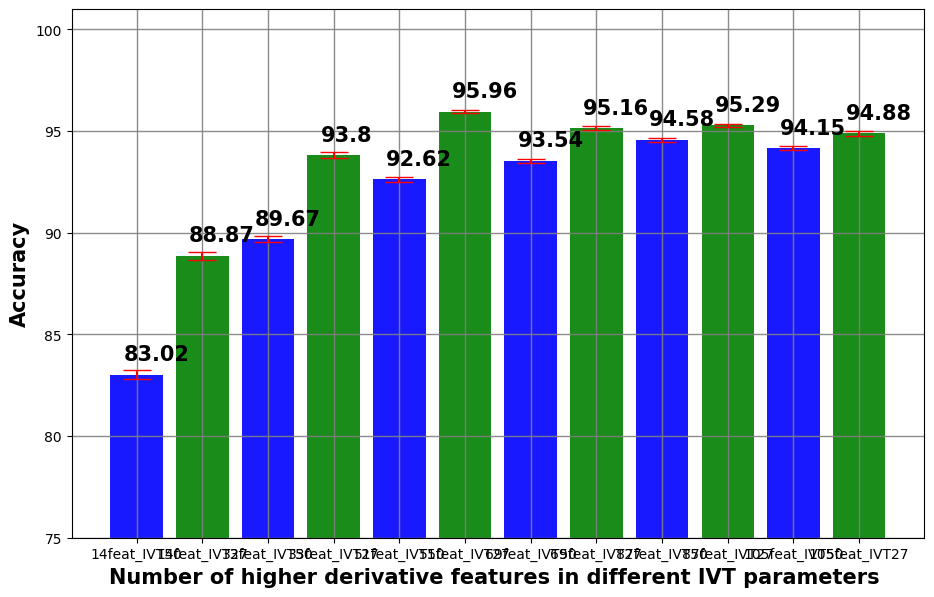

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure


figure(num=None, figsize=(11, 7), dpi=100, facecolor='w', edgecolor='k')
#ax = fig.add_axes([0,0,1,1])
methods = ['14feat_IVT50', '14feat_IVT27', '33feat_IVT50', '33feat_IVT27', '51feat_IVT50', '51feat_IVT27', '69feat_IVT50', '69feat_IVT27', '87feat_IVT50', '87feat_IVT27', '105feat_IVT50', '105feat_IVT27']
accuracy_RAN = [83.02, 88.87,89.67,93.80,92.62,95.96,93.54,95.16,94.58,95.29,94.15,94.88 ]
std_RAN = [0.22 ,0.19 ,0.15 ,0.15 ,0.13 ,0.09 ,0.10 ,0.11, 0.10 ,0.08 ,0.09, 0.10]



plt.yticks(np.arange(50,101,5))
plt.ylim([75, 101])
#plt.axhline(y = 63.8, linestyle = 'dashed')
# plt.title("Best accuracies achieved in all the Ensemble methods for Dyslexia dataset (Gender Prediction)")
plt.xlabel('Number of higher derivative features in different IVT parameters ',fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy',fontweight ='bold', fontsize = 15)
barplot = plt.bar(methods,accuracy_RAN,yerr=std_RAN, align='center',
       alpha=0.9,
       ecolor='red',
       capsize=10,
       color = ['blue', 'green', 'blue', 'green', 'blue', 'green', 'blue', 'green', 'blue', 'green', 'blue', 'green']
                 )
for bar in barplot:
    yval = bar.get_height()
    plt.text(bar.get_x()-0.2 + bar.get_width()/2.0, yval+0.5, float(yval), va='bottom',fontsize = 15, fontweight ='bold') #va: vertical alignment y positional argument
plt.grid(b = False, color ='grey', linewidth = 1,
        alpha = 0.9)
plt.legend
plt.show()

##yellow


0.3089595442772387


<ipython-input-4-7a11d60bbe1c>:57: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = False, color ='grey', linewidth = 1,
<ipython-input-4-7a11d60bbe1c>:57: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b = False, color ='grey', linewidth = 1,
<ipython-input-4-7a11d60bbe1c>:62: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b = False, color ='grey', linewidth = 1,
<ipython-input-4-7a11d60bbe1c>:62: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b = False, color ='grey', linewidth = 1,


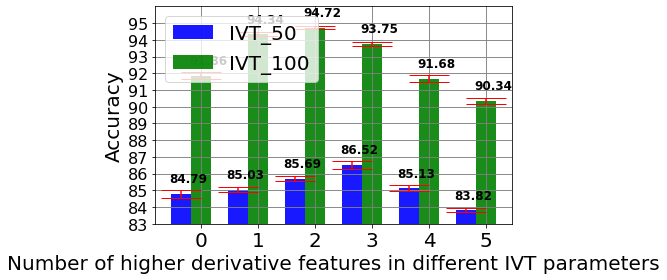

In [4]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure

TEX_87_feat_CV = [93.01, 92.94, 93.39, 93.39, 93.75, 93.50, 93.82, 93.78, 93.65, 93.8]
RAN_87_feat_CV = [94.94,95.56,95.41,94.94,95.05,94.51,94.93,95.5,95.35,95.19]
print(np.std(RAN_87_feat_CV))
# exit()
# data to plot
n_groups = 6
accuracy_RAN_ivt50 = [83.02,89.67,92.62,93.54,94.58,94.15]
std_RAN_ivt50 = [0.22,0.15,0.13,0.10,0.10,0.09]
accuracy_RAN_ivt27 = [88.87,93.80,95.96,95.16,95.29,94.88]
std_RAN_ivt27 = [0.19,0.15,0.09,0.10,0.08,0.10]

accuracy_TEX_ivt50  = [84.30, 89.81 , 90.90, 91.73 , 91.96 , 90.86]
std_TEX_ivt50  = [ 0.17, 0.11, 0.10, 0.12, 0.08, 0.14]
accuracy_TEX_ivt27  = [ 85.77, 91.09, 93.23, 93.12, 93.39, 93.04]
std_TEX_ivt27  = [ 0.13, 0.16, 0.13, 0.12, 0.09, 0.11]

accuracy_VST_ivt50  = [ 84.79, 85.03, 85.69, 86.52, 85.13, 83.82]
std_VST_ivt50  = [ 0.22, 0.15, 0.16, 0.23, 0.17, 0.14]
accuracy_VST_ivt27  = [ 91.86, 94.34, 94.72, 93.75, 91.68, 90.34]
std_VST_ivt27  = [ 0.22, 0.13, 0.08, 0.13, 0.22, 0.19]

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.9  ## alpha of the color
font_size = 20
plt.yticks(np.arange(80,96,1))
plt.ylim([83, 96])

rects1 = plt.bar(index, accuracy_VST_ivt50, bar_width,
alpha=opacity,yerr=std_VST_ivt50, align='center', ecolor='red', capsize=font_size,
color='b',
label='IVT_50')

rects2 = plt.bar(index + bar_width, accuracy_VST_ivt27, bar_width,
alpha=opacity,yerr=std_VST_ivt27, align='center', ecolor='red', capsize=font_size,
color='g',
label='IVT_100')

plt.xlabel('Number of higher derivative features in different IVT parameters', fontsize = font_size)
plt.ylabel('Accuracy', fontsize = font_size)
# plt.title('')
# plt.xticks(index + bar_width, ('14_feat', '33_feat', '51_feat', '69_feat', '87_feat', '105_feat'), fontsize = font_size)
plt.xticks(index + bar_width, ('0', '1', '2', '3', '4', '5'), fontsize = font_size)
plt.yticks(fontsize= 16)
plt.legend(['IVT_50','IVT_100'], prop={"size": font_size},loc='upper left')
# plt.legend()
for bar in rects1:
    yval = bar.get_height()
    plt.text(bar.get_x()-0.2 + bar.get_width()/2.0, yval+0.5, float(yval), va='bottom',fontsize = 12, fontweight ='bold') #va: vertical alignment y positional argument
plt.grid(b = False, color ='grey', linewidth = 1,
        alpha = opacity)
for bar in rects2:
    yval = bar.get_height()
    plt.text(bar.get_x()-0.2 + bar.get_width()/2.0, yval+0.5, float(yval), va='bottom',fontsize = 12, fontweight ='bold') #va: vertical alignment y positional argument
plt.grid(b = False, color ='grey', linewidth = 1,
        alpha = opacity)
plt.tight_layout()
plt.show()
exit()

In [ ]:
## This script used with bioeye data for:
## First part is to generate the outliers count and durations
## Second part is for extract only blinking and microsleep features
## Third part is for the statistical calculations
## Fourth is ploting the outliers details
## fifth Check if there is nan in the features columns
## sixth plot the blinking features

##    validity = np.genfromtxt(pjoin(data_folder_path, filename), skip_header=1, usecols=[3])
    ##print(validity)
    ##print(len(users))

from os.path import basename, join as pjoin
import os
from enum import Enum, auto
from itertools import repeat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

########## The first part of generating the outliers count
# data_folder_path = '/../schau_mir_in_die_augen/data/BioEye2015_DevSets/RAN_30min_dv'
# users = list(sorted(set([basename(f.path)[:6]
#                                  for f in os.scandir(data_folder_path)
#                                  if f.is_file()])))
# session = 2
# count2 = []
# n = []
# r = []
# for user in users:
#     filename = '{}_{}.txt'.format(user, session)
#     validity = np.genfromtxt(pjoin(data_folder_path, filename), skip_header=1, usecols=[3])
#     print(validity)
#     print(len(users))
#     skipcount, count1 = [], []
#     for i in range(len(validity)):
#         k = 0
#         if i in skipcount:
#             continue
#         elif validity[i] == 0:
#             k += 1
#             for j in range(i + 1, len(validity)):
#                 if validity[j] == 0 or validity[j] == 0:  ## to count the blink outside the stimuli
#                     k += 1
#                     skipcount += [j]
#                 else:
#                     count1 += [k]
#                     break
#     if count1 == []:
#         users_1 = 1
#         count2.append(0)
#         r.append(0)
#     else:
#         users_1 = len(count1)
#         count2.extend(count1)
#         r.extend(repeat(len(count1), len(count1)))
#     print(count1)
#     # print(count1)
#     # count2.extend(count1)
#     n.extend(repeat(user, users_1))
#     # r.extend(repeat(len(count1), len(count1)))
#     q = [x / 250 for x in count2]
#     print(user)
#     df = pd.DataFrame({"User": n, "Blinking": count2, "No_of_Blink": r, "Time": q})
#     # df.to_csv(r'/../schau_mir_in_die_augen/data/BioEye2015_DevSets/outlier_count_RAN_S2.csv', index=False)
# exit()

# ################ Second part of extracting only blinking and microsleep features: (session 2 or 1)
# data_s2 = pd.read_csv("/../schau_mir_in_die_augen/data/BioEye2015_DevSets/outlier_count_RAN_S1.csv")
# outlier_dur_s2 = data_s2['Time']
# user_2 = data_s2['User']
# for i in range(len(outlier_dur_s2)):
#     # print("iam here",i)
#     # exit()
#     if outlier_dur_s2[i] < 0.08 or outlier_dur_s2[i] > 0.5: ## for only blinking
#     # if outlier_dur_s2[i] < 0.5: ## for only microsleeping
#         data_s2['Time'][i] = 0
#         new_user_2 = user_2[i]
#         a = data_s2.index[data_s2['User'] == new_user_2].tolist()
#         for x in a:
#             if data_s2['No_of_Blink'][x] == 0:
#                 pass
#             else:
#                 data_s2['No_of_Blink'][x] -= 1
#     elif outlier_dur_s2[i] >= 0.08 and outlier_dur_s2[i] <= 0.5: ## for only blinking
#     # elif outlier_dur_s2[i] > 0.5:  ## for only microsleeping
#         pass
#     else:
#         pass
# data_s2 = data_s2.drop(data_s2[(data_s2.Time == 0) & (data_s2.No_of_Blink >= 1)].index) ## to drop the rows with 0 time if the blink number more than 1
# print("data_s2",data_s2)
# data_s2.to_csv(r"/../schau_mir_in_die_augen/data/BioEye2015_DevSets/Blinking_count_RAN_S1.csv",index=False)
# exit()


######### Third part of statistical calculations

# blinking_data_s2 = pd.read_csv("/../schau_mir_in_die_augen/data/BioEye2015_DevSets/Blinking_count_RAN_S2.csv")
# mean_df_s2 = blinking_data_s2.groupby('User').agg({'No_of_Blink': ['mean'], 'Time': ['mean', 'sum', 'min', 'max', 'var', 'skew']})
# # mean_df_s2 = blinking_data_s2.groupby('User').apply(pd.DataFrame.kurt)
# # print(mean_df_s2)
# mean_df_s2.to_csv(r'/../schau_mir_in_die_augen/data/BioEye2015_DevSets/statistical_blinking_count_RAN2.csv', index=True)
# exit()

# ################################# Fourth ploting the outliers
data_s1 = pd.read_csv("/home/sahar/user_aspect_branch_code/schau_mir_in_die_augen/data/BioEye2015_DevSets/TEX_outliers_blink/TEX_outliers_blinking/outlier_count_TEX_S1.csv")
data_s2 = pd.read_csv("/home/sahar/user_aspect_branch_code/schau_mir_in_die_augen/data/BioEye2015_DevSets/TEX_outliers_blink/TEX_outliers_blinking/outlier_count_TEX_S2.csv")
outlier_dur_s1 = data_s1['Time'] ######### ALL user data trajectory session1
outlier_dur_s2 = data_s2['Time'] ######### ALL user data trajectory session2

# User_data_S1 = data_s1['User']    ######### ADDING ALL USER  session1
# User = list(User_data_S1)
User_data_S2 = data_s2['User']  ######### ADDING ALL USER session2
User=list(User_data_S2)
c = []
skipcount = []
for i in range(len(User)):
    if i in skipcount:
        continue
    elif i == 0:
        a = User[i]
        c += [i]
    else:
        if User[i] == a:
            skipcount += [i]
        else:
            a = User[i]
            c += [i]

print("Total number of outliers s1", len(outlier_dur_s1))
print("Total number of outliers s2", len(outlier_dur_s2))
both_sessions_dur = pd.concat([outlier_dur_s1,outlier_dur_s2], axis=0, ignore_index=True)
print("Total number of outliers both sessions", len(both_sessions_dur))

outlier_dur = data_s1['Time']      ######### ALL user data trajectory session1
# outlier_dur = data_s2['Time']    ######### ALL user data trajectory session2
# outlier_dur = both_sessions_dur  ######### ALL user data trajectory both sessions

print("Total number of outliers (check the session number)", len(outlier_dur))
microsleep = np.where(np.logical_and(outlier_dur>=0.5, outlier_dur<=10))
print("Microsleeps", microsleep)
print("Number of Microsleeps", len(microsleep[0]))
blinks = np.where(np.logical_and(outlier_dur>=0.08, outlier_dur<=0.5))
print("Blinks", blinks)
print("Number of Blinks", len(blinks[0]))
# unknown = np.where(np.logical_and(outlier_dur>0.5, outlier_dur<0.8))
# print("Unknowns", unknown)
# print("Number of Unknowns", len(unknown[0]))
device_failure = np.where(np.logical_and(outlier_dur>=0.0, outlier_dur<0.08))  ## these should correspond to device failure
print("device failure", device_failure)
print("Number of device failure", len(device_failure[0]))
print("Min outlier duration", np.min(outlier_dur))
print("Max outlier duration", np.max(outlier_dur))
plt.figure(1)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.title('Outliers durations over all the 153 users in session1 of TEX data', fontsize=25)
plt.grid(True)
plt.plot(outlier_dur) ## data of one of the sessions
# plt.plot(both_sessions_dur) ## data both the sessions
#
x = np.arange(len(data_s1))  ## data of one of the sessions
# x = np.arange(both_sessions_dur) ## data both the sessions
y = 0.0*x + 0.08
plt.plot(x, y, '-r', label='blinking min dur. threshold=0.08')
y = 0.0*x + 0.5
plt.plot(x, y, '-r', label='blinking max dur. threshold=0.5')
y = 0.0*x + 0.5
plt.plot(x, y, '-g', label='microsleeping min dur. threshold=0.5')
y = 0.0*x + 10.0
plt.plot(x, y, '-g', label='microsleeping max dur. threshold=10')
plt.ylim([0, 0.51])
plt.xlim([0, 400])
xcoords = c    #####ADDING ALL USER VERTICAL LINES
for xc in xcoords[0:6]:
    plt.axvline(x=xc, color='k', linestyle='--')
plt.ylabel('Outliers durations', fontsize=25)
plt.legend()
plt.show()
exit()

#############################
### to merge csv features:
# features_sacc_df = pd.read_csv('/../schau_mir_in_die_augen/data/BioEye2015_DevSets/TEX_blinking_features/blinking_count_Tex_S2.csv')
# bioeye_outlier_RAN_df = pd.read_csv('/../schau_mir_in_die_augen/data/BioEye2015_DevSets/TEX_blinking_features/statistical_blinking_count_Tex_S2.csv')
# merge_df = pd.merge(features_sacc_df, bioeye_outlier_RAN_df, on="User")
# merge_df.to_csv(r'/../schau_mir_in_die_augen/data/BioEye2015_DevSets/TEX_blinking_features/TEX_S2_merge_statistical_blinking_and_microsleep.csv', index=False)
# exit()

## features_sacc.drop(['User'], axis=1, inplace=True)
# merge_df = pd.read_csv('/../schau_mir_in_die_augen/data/BioEye2015_DevSets/THEneeeew_RAN_S1_merge_statistical_blinking_and_microsleep.csv')
# exit()

# features_sacc =  features_sacc_df.groupby('user', as_index=True, sort=False).sum()
# # features_sacc.drop(['User'], axis=1, inplace=True)
# print(features_sacc)
# features_sacc.to_csv(r'/../schau_mir_in_die_augen/data/BioEye2015_DevSets/bioeye_ran_features/features_bioeyeRAN_fillnan_of_blinking_zero/sum_my_approach_features_train_sac_S2.csv', index=False)
# exit()

#############################
### Fifth Check if there is nan in the features
# data = pd.read_csv("/../schau_mir_in_die_augen/data/BioEye2015_DevSets/statistical_outlier_count_RAN.csv")
# cols2 = data.columns
# print("number of the columns in this datafram is",len(cols2))
# # data['Time_kurt_S1'].fillna(data['Time_kurt_S1'].mean(), inplace=True)  ## to remove the nan and fill it with mean (note: we filled with zero in case of blinking and MS)
# for i in cols2:
#     if i != 'user':
#         # nans = np.isnan(data[i]).sum()
#         nans = data[i].isnull().values.any()
#         print(i)
#         print(nans)
#         if nans > 0:
#             print("we have nan in this feature column here::",i, "the data::",  data[i])
# exit()

###################  Sixth plot blinking features
# # cols2 = ['No_of_outlier_mean_S1','Time_sum_S1','Time_mean_S1','Time_min_S1','Time_max_S1','Time_var_S1','Time_skew_S1','Time_kurt_S1']
# blinking_data = pd.read_csv("/../schau_mir_in_die_augen/data/BioEye2015_DevSets/chek_nan_filter/statistical_blinking_count_RAN(fillnanwithzero).csv")
#
# import matplotlib.pyplot as plt
# plt.title('Analysis')
# A = plt.figure(1)
# feature1 = blinking_data['No_of_outlier_mean_S2']
# user = blinking_data['User']
# plt.bar(user,feature1, color = 'b', width = 0.8, label='No_of_blinking_mean_S2_Bioeye_RAN')
# plt.legend(loc='upper center', fontsize=14)
# plt.ylim([0, 80])
# plt.xlim([0, 154])
# # plt.ylabel('', fontsize=12)
# plt.xlabel('Users ID', fontsize=14)
# plt.xticks(np.arange(0, 154, 1), rotation='vertical')
# plt.yticks(np.arange(0, 80, 2))
# plt.grid(True)
#
# b = plt.figure(2)
# feature2 = blinking_data['Time_sum_S2']
# user = blinking_data['User']
# plt.bar(user,feature2, color = 'r', width = 0.8, label='Time_sum_S2_Bioeye_RAN')
# plt.legend(loc='upper center', fontsize=14)
# plt.ylim([0, 18])
# plt.xlim([0, 154])
# # plt.ylabel('', fontsize=12)
# plt.xlabel('Users ID', fontsize=14)
# plt.xticks(np.arange(0, 154, 1), rotation='vertical')
# plt.yticks(np.arange(0, 18, 1))
# plt.grid(True)
#
# c = plt.figure(3)
# feature1 = blinking_data['Time_mean_S2']
# user = blinking_data['User']
# plt.bar(user,feature1, color = 'b', width = 0.8, label='Time_mean_S2_Bioeye_RAN')
# plt.legend(loc='upper center', fontsize=14)
# plt.ylim([0, 0.36])
# plt.xlim([0, 154])
# # plt.ylabel('', fontsize=12)
# plt.xlabel('Users ID', fontsize=14)
# plt.xticks(np.arange(0, 154, 1), rotation='vertical')
# plt.yticks(np.arange(0, 0.5, 0.02))
# plt.grid(True)
#
# d = plt.figure(4)
# feature2 = blinking_data['Time_min_S2']
# user = blinking_data['User']
# plt.bar(user,feature2, color = 'b', width = 0.8, label='Time_min_S2_Bioeye_RAN')
# plt.legend(loc='upper center', fontsize=14)
# plt.ylim([0, 0.4])
# plt.xlim([0, 154])
# # plt.ylabel('', fontsize=12)
# plt.xlabel('Users ID', fontsize=14)
# plt.xticks(np.arange(1, 154, 1), rotation='vertical')
# plt.yticks(np.arange(0, 0.4, 0.01))
# plt.grid(True)
#
# e = plt.figure(5)
# feature1 = blinking_data['Time_max_S2']
# user = blinking_data['User']
# plt.bar(user,feature1, color = 'b', width = 0.8, label='Time_max_S2_Bioeye_RAN')
# plt.legend(loc='upper center', fontsize=14)
# plt.ylim([0, 0.6])
# plt.xlim([0, 154])
# # plt.ylabel('', fontsize=12)
# plt.xlabel('Users ID', fontsize=14)
# plt.xticks(np.arange(0, 154, 1), rotation='vertical')
# plt.yticks(np.arange(0, 0.6, 0.01))
# plt.grid(True)
#
# f = plt.figure(6)
# feature2 = blinking_data['Time_var_S2']
# user = blinking_data['User']
# plt.bar(user,feature2, color = 'b', width = 0.8, label='Time_var_S2_Bioeye_RAN')
# plt.legend(loc='upper center', fontsize=14)
# plt.ylim([0, 0.06])
# plt.xlim([0, 154])
# # plt.ylabel('', fontsize=12)
# plt.xlabel('Users ID', fontsize=14)
# plt.xticks(np.arange(1, 154, 1), rotation='vertical')
# plt.yticks(np.arange(0, 0.06, 0.01))
# plt.grid(True)
#
# g = plt.figure(7)
# feature1 = blinking_data['Time_skew_S2']
# user = blinking_data['User']
# plt.bar(user,feature1, color = 'r', width = 0.8, label='Time_skew_S2_Bioeye_RAN')
# plt.legend(loc='upper center', fontsize=14)
# plt.ylim([0, 3.5])
# plt.xlim([0, 154])
# # plt.ylabel('', fontsize=12)
# plt.xlabel('Users ID', fontsize=14)
# plt.xticks(np.arange(0, 154, 1), rotation='vertical')
# plt.yticks(np.arange(0, 3.5, 0.1))
# plt.grid(True)
#
#
# h = plt.figure(8)
# feature2 = blinking_data['Time_kurt_S2']
# user = blinking_data['User']
# plt.bar(user,feature2, color = 'b', width = 0.8, label='Time_kurt_S2_Bioeye_RAN')
# plt.legend(loc='upper center', fontsize=14)
# plt.ylim([0, 18])
# plt.xlim([0, 154])
# # plt.ylabel('', fontsize=12)
# plt.xlabel('Users ID', fontsize=14)
# plt.xticks(np.arange(0, 154, 1), rotation='vertical')
# plt.yticks(np.arange(0, 18, 1))
# plt.grid(True)
# plt.show()
# exit()
